# Wine Quality Dataset

The Wine Quality Dataset involves predicting the quality of white wines on a scale given chemical measures of each wine.

It is a multi-class classification problem, but could also be framed as a regression problem. The number of observations for each class is not balanced. There are 4,898 observations with 11 input variables and one output variable. The variable names are as follows:

### Input Features for classification
- Fixed acidity.
- Volatile acidity.
- Citric acid.
- Residual sugar.
- Chlorides.
- Free sulfur dioxide.
- Total sulfur dioxide.
- Density.
- pH.
- Sulphates.
- Alcohol.

### Output Feature for classification
- Quality (score between 0 and 10).

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from optuna.visualization.matplotlib import plot_param_importances

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/manish72/ineuron_ClassAssignments/main/Optuna_Classifer_Probelm/winequality-red.csv")

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
df = df[~df.duplicated()]

In [9]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [10]:
df['quality'].value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

In [11]:
X=df.drop(["quality"],axis=1)

In [12]:
y=df["quality"]

In [13]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [14]:
y

0       5
1       5
2       5
3       6
5       5
       ..
1593    6
1594    5
1595    6
1597    5
1598    6
Name: quality, Length: 1359, dtype: int64

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=25)

In [16]:
X_train.shape,X_test.shape

((1019, 11), (340, 11))

In [17]:
y_train.shape,y_test.shape

((1019,), (340,))

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit_transform(X_train)

array([[ 0.05556106,  1.14595167, -0.80746929, ..., -0.7789901 ,
         0.97984883, -0.76471258],
       [-0.40287393,  1.390986  , -0.30277003, ..., -1.23590452,
        -1.29989078, -1.13510414],
       [-0.17365643,  3.51461692, -0.30277003, ...,  0.20011225,
        -1.11991134,  0.06866844],
       ...,
       [ 0.45669167, -0.3514804 ,  1.1103879 , ..., -1.49699848,
        -0.39999357, -1.22770203],
       [ 2.40504036, -0.40593247,  1.81696687, ..., -2.08445989,
         1.27981456, -0.20912523],
       [-0.63209142,  0.38362262, -1.26169862, ...,  0.98339413,
        -0.75995245,  1.27244102]])

In [20]:
X_train.shape

(1019, 11)

In [21]:
X_test=scaler.transform(X_test)

In [22]:
X_test.shape

(340, 11)

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [24]:
y_test = le.transform(y_test)

In [25]:
model = RandomForestClassifier(n_estimators=50,max_depth=8,criterion = 'gini' ,oob_score=True,random_state=30)

In [26]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=50, oob_score=True,
                       random_state=30)

In [27]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [28]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
y_pred

array([2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3,
       2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 1, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3,

In [30]:
accuracy_score(y_test,y_pred)

0.45294117647058824

In [31]:
def objective(trail,data=X,target=y):  
  le = LabelEncoder()
  train_x,test_x,train_y,test_y=train_test_split(data,target,test_size=0.25,random_state=30)
  train_y = le.fit_transform(train_y)
  test_y = le.transform(test_y)
  param={
      "tree_method":"gpu_hist",
      'subsample' :trail.suggest_float('subsample' , 0.1,1,step=0.1),
      'learning_rate' : trail.suggest_float('learning_rate' , 0.001,0.008,step=0.001),
      'n_estimators' :100,
      'max_depth' :trail.suggest_int('max_depth',3,8,step=1),
      'random_state' :trail.suggest_int('random_state',10,50),
      'min_child_weight' :trail.suggest_int('min_child_weight' ,1,20)
      }
  Xgb_classifier_model=xgb.XGBClassifier(**param)
  Xgb_classifier_model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=True)
  y_pred = Xgb_classifier_model.predict(X_test)
  acc = accuracy_score(y_pred, test_y)
  print(f"Model Accuracy: {round(acc, 6)}")
  print(f"Model Parameters: {param}")
  return acc  # return our objective value

In [32]:
find_params=optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
find_params.optimize(objective,n_trials=100)
find_params.best_trial.params

[I 2023-05-26 15:29:35,459] A new study created in memory with name: no-name-b81e4627-19f4-4c12-9ca4-b45e216be457


[0]	validation_0-mlogloss:1.78763
[1]	validation_0-mlogloss:1.78332
[2]	validation_0-mlogloss:1.77930
[3]	validation_0-mlogloss:1.77532
[4]	validation_0-mlogloss:1.77122
[5]	validation_0-mlogloss:1.76726
[6]	validation_0-mlogloss:1.76317
[7]	validation_0-mlogloss:1.75915
[8]	validation_0-mlogloss:1.75519
[9]	validation_0-mlogloss:1.75145
[10]	validation_0-mlogloss:1.74763
[11]	validation_0-mlogloss:1.74376
[12]	validation_0-mlogloss:1.73985
[13]	validation_0-mlogloss:1.73602
[14]	validation_0-mlogloss:1.73251
[15]	validation_0-mlogloss:1.72880
[16]	validation_0-mlogloss:1.72506
[17]	validation_0-mlogloss:1.72128
[18]	validation_0-mlogloss:1.71777
[19]	validation_0-mlogloss:1.71410
[20]	validation_0-mlogloss:1.71060
[21]	validation_0-mlogloss:1.70712
[22]	validation_0-mlogloss:1.70365
[23]	validation_0-mlogloss:1.70007
[24]	validation_0-mlogloss:1.69645
[25]	validation_0-mlogloss:1.69307
[26]	validation_0-mlogloss:1.68950
[27]	validation_0-mlogloss:1.68609
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:29:37,269] Trial 0 finished with value: 0.3352941176470588 and parameters: {'subsample': 0.9, 'learning_rate': 0.004, 'max_depth': 5, 'random_state': 11, 'min_child_weight': 2}. Best is trial 0 with value: 0.3352941176470588.


Model Accuracy: 0.335294
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 5, 'random_state': 11, 'min_child_weight': 2}
[0]	validation_0-mlogloss:1.78861
[1]	validation_0-mlogloss:1.78549
[2]	validation_0-mlogloss:1.78243
[3]	validation_0-mlogloss:1.77934
[4]	validation_0-mlogloss:1.77629
[5]	validation_0-mlogloss:1.77324
[6]	validation_0-mlogloss:1.77023
[7]	validation_0-mlogloss:1.76732
[8]	validation_0-mlogloss:1.76435
[9]	validation_0-mlogloss:1.76139
[10]	validation_0-mlogloss:1.75850
[11]	validation_0-mlogloss:1.75560
[12]	validation_0-mlogloss:1.75270
[13]	validation_0-mlogloss:1.74980
[14]	validation_0-mlogloss:1.74691
[15]	validation_0-mlogloss:1.74399
[16]	validation_0-mlogloss:1.74113
[17]	validation_0-mlogloss:1.73822
[18]	validation_0-mlogloss:1.73533
[19]	validation_0-mlogloss:1.73249
[20]	validation_0-mlogloss:1.72963
[21]	validation_0-mlogloss:1.72679
[22]	validation_0-mlogloss:1.72400
[23]	validat

[I 2023-05-26 15:29:38,357] Trial 1 finished with value: 0.36764705882352944 and parameters: {'subsample': 1.0, 'learning_rate': 0.003, 'max_depth': 6, 'random_state': 33, 'min_child_weight': 7}. Best is trial 1 with value: 0.36764705882352944.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 6, 'random_state': 33, 'min_child_weight': 7}
[0]	validation_0-mlogloss:1.78596
[1]	validation_0-mlogloss:1.78068
[2]	validation_0-mlogloss:1.77524
[3]	validation_0-mlogloss:1.77016
[4]	validation_0-mlogloss:1.76465
[5]	validation_0-mlogloss:1.75938
[6]	validation_0-mlogloss:1.75403
[7]	validation_0-mlogloss:1.74882
[8]	validation_0-mlogloss:1.74354
[9]	validation_0-mlogloss:1.73824
[10]	validation_0-mlogloss:1.73310
[11]	validation_0-mlogloss:1.72802
[12]	validation_0-mlogloss:1.72365
[13]	validation_0-mlogloss:1.71859
[14]	validation_0-mlogloss:1.71375
[15]	validation_0-mlogloss:1.70911
[16]	validation_0-mlogloss:1.70416
[17]	validation_0-mlogloss:1.69943
[18]	validation_0-mlogloss:1.69476
[19]	validation_0-mlogloss:1.68983
[20]	validation_0-mlogloss:1.68518
[21]	validation_0-mlogloss:1.68044
[22]	validation_0-mlogloss:1.67581
[23]	validat

[I 2023-05-26 15:29:39,243] Trial 2 finished with value: 0.37941176470588234 and parameters: {'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 16}. Best is trial 2 with value: 0.37941176470588234.


Model Accuracy: 0.379412
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78492
[1]	validation_0-mlogloss:1.77813
[2]	validation_0-mlogloss:1.77144
[3]	validation_0-mlogloss:1.76481
[4]	validation_0-mlogloss:1.75833
[5]	validation_0-mlogloss:1.75211
[6]	validation_0-mlogloss:1.74569
[7]	validation_0-mlogloss:1.73943
[8]	validation_0-mlogloss:1.73307
[9]	validation_0-mlogloss:1.72689
[10]	validation_0-mlogloss:1.72086
[11]	validation_0-mlogloss:1.71491
[12]	validation_0-mlogloss:1.70871
[13]	validation_0-mlogloss:1.70294
[14]	validation_0-mlogloss:1.69718
[15]	validation_0-mlogloss:1.69149
[16]	validation_0-mlogloss:1.68575
[17]	validation_0-mlogloss:1.68012
[18]	validation_0-mlogloss:1.67459
[19]	validation_0-mlogloss:1.66904
[20]	validation_0-mlogloss:1.66360
[21]	validation_0-mlogloss:1.65823
[22]	validation_0-mlogloss:1.65303
[23]	valida

[I 2023-05-26 15:29:40,043] Trial 3 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.9, 'learning_rate': 0.007, 'max_depth': 3, 'random_state': 32, 'min_child_weight': 14}. Best is trial 2 with value: 0.37941176470588234.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 3, 'random_state': 32, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.78595
[1]	validation_0-mlogloss:1.78021
[2]	validation_0-mlogloss:1.77443
[3]	validation_0-mlogloss:1.76875
[4]	validation_0-mlogloss:1.76316
[5]	validation_0-mlogloss:1.75743
[6]	validation_0-mlogloss:1.75212
[7]	validation_0-mlogloss:1.74661
[8]	validation_0-mlogloss:1.74102
[9]	validation_0-mlogloss:1.73579
[10]	validation_0-mlogloss:1.73054
[11]	validation_0-mlogloss:1.72530
[12]	validation_0-mlogloss:1.72032
[13]	validation_0-mlogloss:1.71512
[14]	validation_0-mlogloss:1.70987
[15]	validation_0-mlogloss:1.70469
[16]	validation_0-mlogloss:1.69944
[17]	validation_0-mlogloss:1.69444
[18]	validation_0-mlogloss:1.68971
[19]	validation_0-mlogloss:1.68492
[20]	validation_0-mlogloss:1.67987
[21]	validation_0-mlogloss:1.67505
[22]	validation_0-mlogloss:1.67005
[23]	valida

[I 2023-05-26 15:29:41,250] Trial 4 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.9, 'learning_rate': 0.006, 'max_depth': 7, 'random_state': 31, 'min_child_weight': 15}. Best is trial 2 with value: 0.37941176470588234.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 7, 'random_state': 31, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.78446
[1]	validation_0-mlogloss:1.77796
[2]	validation_0-mlogloss:1.77219
[3]	validation_0-mlogloss:1.76545
[4]	validation_0-mlogloss:1.75991
[5]	validation_0-mlogloss:1.75437
[6]	validation_0-mlogloss:1.74876
[7]	validation_0-mlogloss:1.74294
[8]	validation_0-mlogloss:1.73710
[9]	validation_0-mlogloss:1.73200
[10]	validation_0-mlogloss:1.72642
[11]	validation_0-mlogloss:1.72125
[12]	validation_0-mlogloss:1.71566
[13]	validation_0-mlogloss:1.71037
[14]	validation_0-mlogloss:1.70489
[15]	validation_0-mlogloss:1.69952
[16]	validation_0-mlogloss:1.69429
[17]	validation_0-mlogloss:1.68899
[18]	validation_0-mlogloss:1.68355
[19]	validation_0-mlogloss:1.67814
[20]	validation_0-mlogloss:1.67341
[21]	validation_0-mlogloss:1.66893
[22]	validation_0-mlogloss:1.66414
[23]	valida

[I 2023-05-26 15:29:42,237] Trial 5 finished with value: 0.3911764705882353 and parameters: {'subsample': 0.2, 'learning_rate': 0.007, 'max_depth': 5, 'random_state': 34, 'min_child_weight': 10}. Best is trial 5 with value: 0.3911764705882353.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 5, 'random_state': 34, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.78413
[1]	validation_0-mlogloss:1.77645
[2]	validation_0-mlogloss:1.76880
[3]	validation_0-mlogloss:1.76132
[4]	validation_0-mlogloss:1.75389
[5]	validation_0-mlogloss:1.74627
[6]	validation_0-mlogloss:1.73956
[7]	validation_0-mlogloss:1.73232
[8]	validation_0-mlogloss:1.72509
[9]	validation_0-mlogloss:1.71824
[10]	validation_0-mlogloss:1.71149
[11]	validation_0-mlogloss:1.70488
[12]	validation_0-mlogloss:1.69842
[13]	validation_0-mlogloss:1.69185
[14]	validation_0-mlogloss:1.68519
[15]	validation_0-mlogloss:1.67891
[16]	validation_0-mlogloss:1.67221
[17]	validation_0-mlogloss:1.66609
[18]	validation_0-mlogloss:1.66011
[19]	validation_0-mlogloss:1.65395
[20]	validation_0-mlogloss:1.64782
[21]	validation_0-mlogloss:1.64185
[22]	validation_0-mlogloss:1.63578
[23]	validation_0-mlogloss:1.62981


[I 2023-05-26 15:29:44,630] Trial 6 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.9, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 31, 'min_child_weight': 14}. Best is trial 5 with value: 0.3911764705882353.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.008, 'n_estimators': 100, 'max_depth': 7, 'random_state': 31, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.78578
[1]	validation_0-mlogloss:1.78018
[2]	validation_0-mlogloss:1.77464
[3]	validation_0-mlogloss:1.76884
[4]	validation_0-mlogloss:1.76330
[5]	validation_0-mlogloss:1.75785
[6]	validation_0-mlogloss:1.75222
[7]	validation_0-mlogloss:1.74684
[8]	validation_0-mlogloss:1.74143
[9]	validation_0-mlogloss:1.73618
[10]	validation_0-mlogloss:1.73103
[11]	validation_0-mlogloss:1.72588
[12]	validation_0-mlogloss:1.72071
[13]	validation_0-mlogloss:1.71570
[14]	validation_0-mlogloss:1.71075
[15]	validation_0-mlogloss:1.70586
[16]	validation_0-mlogloss:1.70131
[17]	validation_0-mlogloss:1.69642
[18]	validation_0-mlogloss:1.69172
[19]	validation_0-mlogloss:1.68710
[20]	validation_0-mlogloss:1.68216
[21]	validation_0-mlogloss:1.67747
[22]	validation_0-mlogloss:1.67271
[23]	valida

[I 2023-05-26 15:29:46,775] Trial 7 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 8, 'random_state': 49, 'min_child_weight': 4}. Best is trial 5 with value: 0.3911764705882353.


[0]	validation_0-mlogloss:1.78877
[1]	validation_0-mlogloss:1.78581
[2]	validation_0-mlogloss:1.78276
[3]	validation_0-mlogloss:1.77991
[4]	validation_0-mlogloss:1.77692
[5]	validation_0-mlogloss:1.77408
[6]	validation_0-mlogloss:1.77129
[7]	validation_0-mlogloss:1.76849
[8]	validation_0-mlogloss:1.76559
[9]	validation_0-mlogloss:1.76288
[10]	validation_0-mlogloss:1.76009
[11]	validation_0-mlogloss:1.75716
[12]	validation_0-mlogloss:1.75439
[13]	validation_0-mlogloss:1.75189
[14]	validation_0-mlogloss:1.74928
[15]	validation_0-mlogloss:1.74657
[16]	validation_0-mlogloss:1.74401
[17]	validation_0-mlogloss:1.74135
[18]	validation_0-mlogloss:1.73853
[19]	validation_0-mlogloss:1.73592
[20]	validation_0-mlogloss:1.73339
[21]	validation_0-mlogloss:1.73096
[22]	validation_0-mlogloss:1.72840
[23]	validation_0-mlogloss:1.72568
[24]	validation_0-mlogloss:1.72321
[25]	validation_0-mlogloss:1.72070
[26]	validation_0-mlogloss:1.71810
[27]	validation_0-mlogloss:1.71547
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:29:48,629] Trial 8 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.4, 'learning_rate': 0.003, 'max_depth': 6, 'random_state': 38, 'min_child_weight': 7}. Best is trial 5 with value: 0.3911764705882353.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 6, 'random_state': 38, 'min_child_weight': 7}
[0]	validation_0-mlogloss:1.78905
[1]	validation_0-mlogloss:1.78620
[2]	validation_0-mlogloss:1.78332
[3]	validation_0-mlogloss:1.78051
[4]	validation_0-mlogloss:1.77783
[5]	validation_0-mlogloss:1.77522
[6]	validation_0-mlogloss:1.77262
[7]	validation_0-mlogloss:1.76979
[8]	validation_0-mlogloss:1.76698
[9]	validation_0-mlogloss:1.76432
[10]	validation_0-mlogloss:1.76156
[11]	validation_0-mlogloss:1.75899
[12]	validation_0-mlogloss:1.75639
[13]	validation_0-mlogloss:1.75371
[14]	validation_0-mlogloss:1.75089
[15]	validation_0-mlogloss:1.74841
[16]	validation_0-mlogloss:1.74573
[17]	validation_0-mlogloss:1.74313
[18]	validation_0-mlogloss:1.74060
[19]	validation_0-mlogloss:1.73822
[20]	validation_0-mlogloss:1.73563
[21]	validation_0-mlogloss:1.73302
[22]	validation_0-mlogloss:1.73064
[23]	validat

[I 2023-05-26 15:29:50,320] Trial 9 finished with value: 0.37941176470588234 and parameters: {'subsample': 0.4, 'learning_rate': 0.003, 'max_depth': 7, 'random_state': 30, 'min_child_weight': 14}. Best is trial 5 with value: 0.3911764705882353.


Model Accuracy: 0.379412
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 7, 'random_state': 30, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.79086
[1]	validation_0-mlogloss:1.78998
[2]	validation_0-mlogloss:1.78916
[3]	validation_0-mlogloss:1.78828
[4]	validation_0-mlogloss:1.78742
[5]	validation_0-mlogloss:1.78655
[6]	validation_0-mlogloss:1.78570
[7]	validation_0-mlogloss:1.78495
[8]	validation_0-mlogloss:1.78417
[9]	validation_0-mlogloss:1.78339
[10]	validation_0-mlogloss:1.78282
[11]	validation_0-mlogloss:1.78198
[12]	validation_0-mlogloss:1.78126
[13]	validation_0-mlogloss:1.78039
[14]	validation_0-mlogloss:1.77966
[15]	validation_0-mlogloss:1.77888
[16]	validation_0-mlogloss:1.77831
[17]	validation_0-mlogloss:1.77750
[18]	validation_0-mlogloss:1.77672
[19]	validation_0-mlogloss:1.77595
[20]	validation_0-mlogloss:1.77519
[21]	validation_0-mlogloss:1.77439
[22]	validation_0-mlogloss:1.77361
[23]	valida

[I 2023-05-26 15:29:51,659] Trial 10 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 21, 'min_child_weight': 10}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 21, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.79090
[1]	validation_0-mlogloss:1.79002
[2]	validation_0-mlogloss:1.78923
[3]	validation_0-mlogloss:1.78837
[4]	validation_0-mlogloss:1.78748
[5]	validation_0-mlogloss:1.78678
[6]	validation_0-mlogloss:1.78599
[7]	validation_0-mlogloss:1.78515
[8]	validation_0-mlogloss:1.78436
[9]	validation_0-mlogloss:1.78346
[10]	validation_0-mlogloss:1.78264
[11]	validation_0-mlogloss:1.78191
[12]	validation_0-mlogloss:1.78111
[13]	validation_0-mlogloss:1.78021
[14]	validation_0-mlogloss:1.77933
[15]	validation_0-mlogloss:1.77847
[16]	validation_0-mlogloss:1.77767
[17]	validation_0-mlogloss:1.77674
[18]	validation_0-mlogloss:1.77588
[19]	validation_0-mlogloss:1.77500
[20]	validation_0-mlogloss:1.77416
[21]	validation_0-mlogloss:1.77336
[22]	validation_0-mlogloss:1.77251
[23]	validation_0-mlogloss:1.77159


[I 2023-05-26 15:29:53,086] Trial 11 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79092
[1]	validation_0-mlogloss:1.79021
[2]	validation_0-mlogloss:1.78934
[3]	validation_0-mlogloss:1.78853
[4]	validation_0-mlogloss:1.78770
[5]	validation_0-mlogloss:1.78686
[6]	validation_0-mlogloss:1.78608
[7]	validation_0-mlogloss:1.78525
[8]	validation_0-mlogloss:1.78430
[9]	validation_0-mlogloss:1.78360
[10]	validation_0-mlogloss:1.78271
[11]	validation_0-mlogloss:1.78183
[12]	validation_0-mlogloss:1.78107
[13]	validation_0-mlogloss:1.78026
[14]	validation_0-mlogloss:1.77956
[15]	validation_0-mlogloss:1.77878
[16]	validation_0-mlogloss:1.77807
[17]	validation_0-mlogloss:1.77740
[18]	validation_0-mlogloss:1.77637
[19]	validation_0-mlogloss:1.77559
[20]	validation_0-mlogloss:1.77477
[21]	validation_0-mlogloss:1.77395
[22]	validation_0-mlogloss:1.77317
[23]	valida

[I 2023-05-26 15:29:54,678] Trial 12 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 10}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.79114
[1]	validation_0-mlogloss:1.79047
[2]	validation_0-mlogloss:1.78988
[3]	validation_0-mlogloss:1.78927
[4]	validation_0-mlogloss:1.78861
[5]	validation_0-mlogloss:1.78794
[6]	validation_0-mlogloss:1.78730
[7]	validation_0-mlogloss:1.78667
[8]	validation_0-mlogloss:1.78612
[9]	validation_0-mlogloss:1.78553
[10]	validation_0-mlogloss:1.78504
[11]	validation_0-mlogloss:1.78441
[12]	validation_0-mlogloss:1.78384
[13]	validation_0-mlogloss:1.78317
[14]	validation_0-mlogloss:1.78264
[15]	validation_0-mlogloss:1.78200
[16]	validation_0-mlogloss:1.78144
[17]	validation_0-mlogloss:1.78083
[18]	validation_0-mlogloss:1.78026
[19]	validation_0-mlogloss:1.77967
[20]	validation_0-mlogloss:1.77902
[21]	validation_0-mlogloss:1.77843
[22]	validation_0-mlogloss:1.77785
[23]	valida

[I 2023-05-26 15:29:56,858] Trial 13 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 21, 'min_child_weight': 18}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 21, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79098
[1]	validation_0-mlogloss:1.79015
[2]	validation_0-mlogloss:1.78925
[3]	validation_0-mlogloss:1.78855
[4]	validation_0-mlogloss:1.78763
[5]	validation_0-mlogloss:1.78678
[6]	validation_0-mlogloss:1.78591
[7]	validation_0-mlogloss:1.78513
[8]	validation_0-mlogloss:1.78440
[9]	validation_0-mlogloss:1.78358
[10]	validation_0-mlogloss:1.78277
[11]	validation_0-mlogloss:1.78208
[12]	validation_0-mlogloss:1.78128
[13]	validation_0-mlogloss:1.78052
[14]	validation_0-mlogloss:1.77967
[15]	validation_0-mlogloss:1.77885
[16]	validation_0-mlogloss:1.77804
[17]	validation_0-mlogloss:1.77731
[18]	validation_0-mlogloss:1.77662
[19]	validation_0-mlogloss:1.77578
[20]	validation_0-mlogloss:1.77492
[21]	validation_0-mlogloss:1.77408
[22]	validation_0-mlogloss:1.77327
[23]	valida

[I 2023-05-26 15:29:59,439] Trial 14 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78985
[1]	validation_0-mlogloss:1.78784
[2]	validation_0-mlogloss:1.78584
[3]	validation_0-mlogloss:1.78391
[4]	validation_0-mlogloss:1.78209
[5]	validation_0-mlogloss:1.78021
[6]	validation_0-mlogloss:1.77825
[7]	validation_0-mlogloss:1.77639
[8]	validation_0-mlogloss:1.77448
[9]	validation_0-mlogloss:1.77252
[10]	validation_0-mlogloss:1.77068
[11]	validation_0-mlogloss:1.76871
[12]	validation_0-mlogloss:1.76679
[13]	validation_0-mlogloss:1.76496
[14]	validation_0-mlogloss:1.76302
[15]	validation_0-mlogloss:1.76112
[16]	validation_0-mlogloss:1.75926
[17]	validation_0-mlogloss:1.75741
[18]	validation_0-mlogloss:1.75551
[19]	validation_0-mlogloss:1.75362
[20]	validation_0-mlogloss:1.75187
[21]	validation_0-mlogloss:1.75012
[22]	validation_0-mlogloss:1.74823
[23]	validation_0-mlogloss:1.74647
[24]	validation_0-mlogloss:1.74469
[25]	validation_0-mlogloss:1.74287
[26]	validation_0-mlogloss:1.74110
[27]	validation_0-mlogloss:1.73934
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:01,058] Trial 15 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.6, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 10, 'min_child_weight': 7}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 10, 'min_child_weight': 7}
[0]	validation_0-mlogloss:1.78984
[1]	validation_0-mlogloss:1.78788
[2]	validation_0-mlogloss:1.78596
[3]	validation_0-mlogloss:1.78406
[4]	validation_0-mlogloss:1.78209
[5]	validation_0-mlogloss:1.78017
[6]	validation_0-mlogloss:1.77814
[7]	validation_0-mlogloss:1.77632
[8]	validation_0-mlogloss:1.77443
[9]	validation_0-mlogloss:1.77243
[10]	validation_0-mlogloss:1.77063
[11]	validation_0-mlogloss:1.76880
[12]	validation_0-mlogloss:1.76684
[13]	validation_0-mlogloss:1.76502
[14]	validation_0-mlogloss:1.76315
[15]	validation_0-mlogloss:1.76136
[16]	validation_0-mlogloss:1.75959
[17]	validation_0-mlogloss:1.75774
[18]	validation_0-mlogloss:1.75591
[19]	validation_0-mlogloss:1.75400
[20]	validation_0-mlogloss:1.75223
[21]	validation_0-mlogloss:1.75039
[22]	validation_0-mlogloss:1.74851
[23]	validat

[I 2023-05-26 15:30:02,267] Trial 16 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.6, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 12}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.79003
[1]	validation_0-mlogloss:1.78839
[2]	validation_0-mlogloss:1.78659
[3]	validation_0-mlogloss:1.78499
[4]	validation_0-mlogloss:1.78329
[5]	validation_0-mlogloss:1.78156
[6]	validation_0-mlogloss:1.77996
[7]	validation_0-mlogloss:1.77832
[8]	validation_0-mlogloss:1.77663
[9]	validation_0-mlogloss:1.77498
[10]	validation_0-mlogloss:1.77327
[11]	validation_0-mlogloss:1.77171
[12]	validation_0-mlogloss:1.76999
[13]	validation_0-mlogloss:1.76862
[14]	validation_0-mlogloss:1.76718
[15]	validation_0-mlogloss:1.76582
[16]	validation_0-mlogloss:1.76438
[17]	validation_0-mlogloss:1.76301
[18]	validation_0-mlogloss:1.76123
[19]	validation_0-mlogloss:1.75985
[20]	validation_0-mlogloss:1.75841
[21]	validation_0-mlogloss:1.75691
[22]	validation_0-mlogloss:1.75535
[23]	valida

[I 2023-05-26 15:30:03,046] Trial 17 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78857
[1]	validation_0-mlogloss:1.78482
[2]	validation_0-mlogloss:1.78116
[3]	validation_0-mlogloss:1.77781
[4]	validation_0-mlogloss:1.77429
[5]	validation_0-mlogloss:1.77060
[6]	validation_0-mlogloss:1.76719
[7]	validation_0-mlogloss:1.76346
[8]	validation_0-mlogloss:1.75987
[9]	validation_0-mlogloss:1.75621
[10]	validation_0-mlogloss:1.75273
[11]	validation_0-mlogloss:1.74884
[12]	validation_0-mlogloss:1.74544
[13]	validation_0-mlogloss:1.74213
[14]	validation_0-mlogloss:1.73869
[15]	validation_0-mlogloss:1.73554
[16]	validation_0-mlogloss:1.73233
[17]	validation_0-mlogloss:1.72886
[18]	validation_0-mlogloss:1.72555
[19]	validation_0-mlogloss:1.72210
[20]	validation_0-mlogloss:1.71885
[21]	validation_0-mlogloss:1.71553
[22]	validation_0-mlogloss:1.71234
[23]	validation_0-mlogloss:1.70941


[I 2023-05-26 15:30:03,980] Trial 18 finished with value: 0.3764705882352941 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.004, 'max_depth': 4, 'random_state': 26, 'min_child_weight': 11}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79080
[1]	validation_0-mlogloss:1.78983
[2]	validation_0-mlogloss:1.78883
[3]	validation_0-mlogloss:1.78783
[4]	validation_0-mlogloss:1.78684
[5]	validation_0-mlogloss:1.78584
[6]	validation_0-mlogloss:1.78485
[7]	validation_0-mlogloss:1.78386
[8]	validation_0-mlogloss:1.78287
[9]	validation_0-mlogloss:1.78192
[10]	validation_0-mlogloss:1.78094
[11]	validation_0-mlogloss:1.77995
[12]	validation_0-mlogloss:1.77894
[13]	validation_0-mlogloss:1.77797
[14]	validation_0-mlogloss:1.77699
[15]	validation_0-mlogloss:1.77599
[16]	validation_0-mlogloss:1.77504
[17]	validation_0-mlogloss:1.77412
[18]	validation_0-mlogloss:1.77315
[19]	validation_0-mlogloss:1.77221
[20]	validation_0-mlogloss:1.77124
[21]	validation_0-mlogloss:1.77029
[22]	validation_0-mlogloss:1.76934
[23]	validation_0-mlogloss:1.76842
[24]	validation_0-mlogloss:1.76744
[25]	validation_0-mlogloss:1.76646
[26]	validation_0-mlogloss:1.76550
[27]	validation_0-mlogloss:1.76455
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:04,955] Trial 19 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.7000000000000001, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 5}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.7000000000000001, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 5}
[0]	validation_0-mlogloss:1.78866
[1]	validation_0-mlogloss:1.78535
[2]	validation_0-mlogloss:1.78246
[3]	validation_0-mlogloss:1.77923
[4]	validation_0-mlogloss:1.77598
[5]	validation_0-mlogloss:1.77242
[6]	validation_0-mlogloss:1.76943
[7]	validation_0-mlogloss:1.76644
[8]	validation_0-mlogloss:1.76365
[9]	validation_0-mlogloss:1.76101
[10]	validation_0-mlogloss:1.75832
[11]	validation_0-mlogloss:1.75571
[12]	validation_0-mlogloss:1.75270
[13]	validation_0-mlogloss:1.74964
[14]	validation_0-mlogloss:1.74660
[15]	validation_0-mlogloss:1.74354
[16]	validation_0-mlogloss:1.74068
[17]	validation_0-mlogloss:1.73798
[18]	validation_0-mlogloss:1.73498
[19]	validation_0-mlogloss:1.73205
[20]	validation_0-mlogloss:1.72979
[21]	validation_0-mlogloss:1.72735
[22]	validation_0-mlogloss:1.724

[I 2023-05-26 15:30:05,680] Trial 20 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 40, 'min_child_weight': 17}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79092
[1]	validation_0-mlogloss:1.79021
[2]	validation_0-mlogloss:1.78948
[3]	validation_0-mlogloss:1.78873
[4]	validation_0-mlogloss:1.78789
[5]	validation_0-mlogloss:1.78721
[6]	validation_0-mlogloss:1.78647
[7]	validation_0-mlogloss:1.78547
[8]	validation_0-mlogloss:1.78467
[9]	validation_0-mlogloss:1.78375
[10]	validation_0-mlogloss:1.78291
[11]	validation_0-mlogloss:1.78193
[12]	validation_0-mlogloss:1.78113
[13]	validation_0-mlogloss:1.78036
[14]	validation_0-mlogloss:1.77943
[15]	validation_0-mlogloss:1.77860
[16]	validation_0-mlogloss:1.77774
[17]	validation_0-mlogloss:1.77699
[18]	validation_0-mlogloss:1.77632
[19]	validation_0-mlogloss:1.77552
[20]	validation_0-mlogloss:1.77478
[21]	validation_0-mlogloss:1.77395
[22]	validation_0-mlogloss:1.77325
[23]	validation_0-mlogloss:1.77251
[24]	validation_0-mlogloss:1.77162
[25]	validation_0-mlogloss:1.77076
[26]	validation_0-mlogloss:1.77009
[27]	validation_0-mlogloss:1.76944
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:06,470] Trial 21 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 18, 'min_child_weight': 10}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78997
[1]	validation_0-mlogloss:1.78801
[2]	validation_0-mlogloss:1.78613
[3]	validation_0-mlogloss:1.78435
[4]	validation_0-mlogloss:1.78248
[5]	validation_0-mlogloss:1.78070
[6]	validation_0-mlogloss:1.77890
[7]	validation_0-mlogloss:1.77711
[8]	validation_0-mlogloss:1.77521
[9]	validation_0-mlogloss:1.77342
[10]	validation_0-mlogloss:1.77150
[11]	validation_0-mlogloss:1.76970
[12]	validation_0-mlogloss:1.76787
[13]	validation_0-mlogloss:1.76613
[14]	validation_0-mlogloss:1.76436
[15]	validation_0-mlogloss:1.76260
[16]	validation_0-mlogloss:1.76081
[17]	validation_0-mlogloss:1.75905
[18]	validation_0-mlogloss:1.75732
[19]	validation_0-mlogloss:1.75566
[20]	validation_0-mlogloss:1.75400
[21]	validation_0-mlogloss:1.75233
[22]	validation_0-mlogloss:1.75055
[23]	validation_0-mlogloss:1.74884
[24]	validation_0-mlogloss:1.74702
[25]	validation_0-mlogloss:1.74514
[26]	validation_0-mlogloss:1.74343
[27]	validation_0-mlogloss:1.74165
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:07,428] Trial 22 finished with value: 0.3941176470588235 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 9}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.394118
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.79099
[1]	validation_0-mlogloss:1.79031
[2]	validation_0-mlogloss:1.78975
[3]	validation_0-mlogloss:1.78904
[4]	validation_0-mlogloss:1.78828
[5]	validation_0-mlogloss:1.78760
[6]	validation_0-mlogloss:1.78689
[7]	validation_0-mlogloss:1.78603
[8]	validation_0-mlogloss:1.78519
[9]	validation_0-mlogloss:1.78439
[10]	validation_0-mlogloss:1.78362
[11]	validation_0-mlogloss:1.78290
[12]	validation_0-mlogloss:1.78226
[13]	validation_0-mlogloss:1.78146
[14]	validation_0-mlogloss:1.78066
[15]	validation_0-mlogloss:1.77989
[16]	validation_0-mlogloss:1.77919
[17]	validation_0-mlogloss:1.77844
[18]	validation_0-mlogloss:1.77774
[19]	validation_0-mlogloss:1.77699
[20]	validation_0-mlogloss:1.77624
[21]	validation_0-mlogloss:1.77548
[22]	validation_0-mlogloss:1.77

[I 2023-05-26 15:30:08,314] Trial 23 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 12}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78990
[1]	validation_0-mlogloss:1.78801
[2]	validation_0-mlogloss:1.78625
[3]	validation_0-mlogloss:1.78431
[4]	validation_0-mlogloss:1.78261
[5]	validation_0-mlogloss:1.78077
[6]	validation_0-mlogloss:1.77896
[7]	validation_0-mlogloss:1.77712
[8]	validation_0-mlogloss:1.77533
[9]	validation_0-mlogloss:1.77352
[10]	validation_0-mlogloss:1.77173
[11]	validation_0-mlogloss:1.77001
[12]	validation_0-mlogloss:1.76841
[13]	validation_0-mlogloss:1.76657
[14]	validation_0-mlogloss:1.76472
[15]	validation_0-mlogloss:1.76304
[16]	validation_0-mlogloss:1.76123
[17]	validation_0-mlogloss:1.75944
[18]	validation_0-mlogloss:1.75776
[19]	validation_0-mlogloss:1.75605
[20]	validation_0-mlogloss:1.75420
[21]	validation_0-mlogloss:1.75236
[22]	validation_0-mlogloss:1.75067
[23]	valida

[I 2023-05-26 15:30:09,521] Trial 24 finished with value: 0.3735294117647059 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 9}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78910
[1]	validation_0-mlogloss:1.78621
[2]	validation_0-mlogloss:1.78354
[3]	validation_0-mlogloss:1.78099
[4]	validation_0-mlogloss:1.77832
[5]	validation_0-mlogloss:1.77592
[6]	validation_0-mlogloss:1.77344
[7]	validation_0-mlogloss:1.77098
[8]	validation_0-mlogloss:1.76847
[9]	validation_0-mlogloss:1.76591
[10]	validation_0-mlogloss:1.76323
[11]	validation_0-mlogloss:1.76066
[12]	validation_0-mlogloss:1.75821
[13]	validation_0-mlogloss:1.75571
[14]	validation_0-mlogloss:1.75328
[15]	validation_0-mlogloss:1.75096
[16]	validation_0-mlogloss:1.74836
[17]	validation_0-mlogloss:1.74587
[18]	validation_0-mlogloss:1.74340
[19]	validation_0-mlogloss:1.74094
[20]	validation_0-mlogloss:1.73835
[21]	validation_0-mlogloss:1.73597
[22]	validation_0-mlogloss:1.73362
[23]	validation_0-mlogloss:1.73119
[24]	validation_0-mlogloss:1.72863
[25]	validation_0-mlogloss:1.72629
[26]	validation_0-mlogloss:1.72390
[27]	validation_0-mlogloss:1.72156
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:11,015] Trial 25 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 12}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.79084
[1]	validation_0-mlogloss:1.79000
[2]	validation_0-mlogloss:1.78925
[3]	validation_0-mlogloss:1.78846
[4]	validation_0-mlogloss:1.78762
[5]	validation_0-mlogloss:1.78682
[6]	validation_0-mlogloss:1.78601
[7]	validation_0-mlogloss:1.78522
[8]	validation_0-mlogloss:1.78452
[9]	validation_0-mlogloss:1.78352
[10]	validation_0-mlogloss:1.78264
[11]	validation_0-mlogloss:1.78187
[12]	validation_0-mlogloss:1.78101
[13]	validation_0-mlogloss:1.78016
[14]	validation_0-mlogloss:1.77939
[15]	validation_0-mlogloss:1.77850
[16]	validation_0-mlogloss:1.77765
[17]	validation_0-mlogloss:1.77686
[18]	validation_0-mlogloss:1.77611
[19]	validation_0-mlogloss:1.77524
[20]	validation_0-mlogloss:1.77442
[21]	validation_0-mlogloss:1.77358
[22]	validation_0-mlogloss:1.77275
[23]	validation_0-mlogloss:1.77198


[I 2023-05-26 15:30:11,946] Trial 26 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 8}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78992
[1]	validation_0-mlogloss:1.78791
[2]	validation_0-mlogloss:1.78599
[3]	validation_0-mlogloss:1.78384
[4]	validation_0-mlogloss:1.78197
[5]	validation_0-mlogloss:1.78013
[6]	validation_0-mlogloss:1.77815
[7]	validation_0-mlogloss:1.77624
[8]	validation_0-mlogloss:1.77438
[9]	validation_0-mlogloss:1.77253
[10]	validation_0-mlogloss:1.77062
[11]	validation_0-mlogloss:1.76870
[12]	validation_0-mlogloss:1.76690
[13]	validation_0-mlogloss:1.76497
[14]	validation_0-mlogloss:1.76327
[15]	validation_0-mlogloss:1.76139
[16]	validation_0-mlogloss:1.75938
[17]	validation_0-mlogloss:1.75753
[18]	validation_0-mlogloss:1.75567
[19]	validation_0-mlogloss:1.75391
[20]	validation_0-mlogloss:1.75220
[21]	validation_0-mlogloss:1.75026
[22]	validation_0-mlogloss:1.74841
[23]	validation_0-mlogloss:1.74652
[24]	validation_0-mlogloss:1.74461
[25]	validation_0-mlogloss:1.74281
[26]	validation_0-mlogloss:1.74088
[27]	validation_0-mlogloss:1.73904
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:13,101] Trial 27 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.5, 'learning_rate': 0.002, 'max_depth': 5, 'random_state': 13, 'min_child_weight': 5}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 5, 'random_state': 13, 'min_child_weight': 5}
[0]	validation_0-mlogloss:1.78814
[1]	validation_0-mlogloss:1.78390
[2]	validation_0-mlogloss:1.78036
[3]	validation_0-mlogloss:1.77687
[4]	validation_0-mlogloss:1.77316
[5]	validation_0-mlogloss:1.76960
[6]	validation_0-mlogloss:1.76618
[7]	validation_0-mlogloss:1.76272
[8]	validation_0-mlogloss:1.75928
[9]	validation_0-mlogloss:1.75559
[10]	validation_0-mlogloss:1.75211
[11]	validation_0-mlogloss:1.74857
[12]	validation_0-mlogloss:1.74494
[13]	validation_0-mlogloss:1.74087
[14]	validation_0-mlogloss:1.73737
[15]	validation_0-mlogloss:1.73353
[16]	validation_0-mlogloss:1.73045
[17]	validation_0-mlogloss:1.72692
[18]	validation_0-mlogloss:1.72347
[19]	validation_0-mlogloss:1.71999
[20]	validation_0-mlogloss:1.71664
[21]	validation_0-mlogloss:1.71358
[22]	validation_0-mlogloss:1.71037
[23]	validat

[I 2023-05-26 15:30:14,035] Trial 28 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 1}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 1}
[0]	validation_0-mlogloss:1.78732
[1]	validation_0-mlogloss:1.78230
[2]	validation_0-mlogloss:1.77727
[3]	validation_0-mlogloss:1.77235
[4]	validation_0-mlogloss:1.76765
[5]	validation_0-mlogloss:1.76329
[6]	validation_0-mlogloss:1.75850
[7]	validation_0-mlogloss:1.75410
[8]	validation_0-mlogloss:1.74943
[9]	validation_0-mlogloss:1.74503
[10]	validation_0-mlogloss:1.74020
[11]	validation_0-mlogloss:1.73600
[12]	validation_0-mlogloss:1.73196
[13]	validation_0-mlogloss:1.72776
[14]	validation_0-mlogloss:1.72362
[15]	validation_0-mlogloss:1.71896
[16]	validation_0-mlogloss:1.71454
[17]	validation_0-mlogloss:1.71010
[18]	validation_0-mlogloss:1.70587
[19]	validation_0-mlogloss:1.70183
[20]	validation_0-mlogloss:1.69775
[21]	validation_0-mlogloss:1.69365
[22]	validation_0-mlogloss:1.68964
[23]	validat

[I 2023-05-26 15:30:15,151] Trial 29 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.005, 'max_depth': 5, 'random_state': 12, 'min_child_weight': 3}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79080
[1]	validation_0-mlogloss:1.78978
[2]	validation_0-mlogloss:1.78884
[3]	validation_0-mlogloss:1.78787
[4]	validation_0-mlogloss:1.78687
[5]	validation_0-mlogloss:1.78591
[6]	validation_0-mlogloss:1.78493
[7]	validation_0-mlogloss:1.78398
[8]	validation_0-mlogloss:1.78301
[9]	validation_0-mlogloss:1.78205
[10]	validation_0-mlogloss:1.78107
[11]	validation_0-mlogloss:1.78013
[12]	validation_0-mlogloss:1.77910
[13]	validation_0-mlogloss:1.77810
[14]	validation_0-mlogloss:1.77716
[15]	validation_0-mlogloss:1.77620
[16]	validation_0-mlogloss:1.77522
[17]	validation_0-mlogloss:1.77427
[18]	validation_0-mlogloss:1.77327
[19]	validation_0-mlogloss:1.77230
[20]	validation_0-mlogloss:1.77134
[21]	validation_0-mlogloss:1.77042
[22]	validation_0-mlogloss:1.76951
[23]	validation_0-mlogloss:1.76860
[24]	validation_0-mlogloss:1.76762
[25]	validation_0-mlogloss:1.76664
[26]	validation_0-mlogloss:1.76572
[27]	validation_0-mlogloss:1.76475
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:16,158] Trial 30 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.7000000000000001, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 11}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.7000000000000001, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.79119
[1]	validation_0-mlogloss:1.79047
[2]	validation_0-mlogloss:1.78986
[3]	validation_0-mlogloss:1.78916
[4]	validation_0-mlogloss:1.78857
[5]	validation_0-mlogloss:1.78793
[6]	validation_0-mlogloss:1.78729
[7]	validation_0-mlogloss:1.78669
[8]	validation_0-mlogloss:1.78603
[9]	validation_0-mlogloss:1.78539
[10]	validation_0-mlogloss:1.78488
[11]	validation_0-mlogloss:1.78432
[12]	validation_0-mlogloss:1.78376
[13]	validation_0-mlogloss:1.78308
[14]	validation_0-mlogloss:1.78238
[15]	validation_0-mlogloss:1.78173
[16]	validation_0-mlogloss:1.78106
[17]	validation_0-mlogloss:1.78047
[18]	validation_0-mlogloss:1.77985
[19]	validation_0-mlogloss:1.77933
[20]	validation_0-mlogloss:1.77867
[21]	validation_0-mlogloss:1.77803
[22]	validation_0-mlogloss:1.77

[I 2023-05-26 15:30:16,859] Trial 31 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 20, 'min_child_weight': 18}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79067
[1]	validation_0-mlogloss:1.78924
[2]	validation_0-mlogloss:1.78801
[3]	validation_0-mlogloss:1.78667
[4]	validation_0-mlogloss:1.78550
[5]	validation_0-mlogloss:1.78409
[6]	validation_0-mlogloss:1.78286
[7]	validation_0-mlogloss:1.78169
[8]	validation_0-mlogloss:1.78035
[9]	validation_0-mlogloss:1.77897
[10]	validation_0-mlogloss:1.77760
[11]	validation_0-mlogloss:1.77647
[12]	validation_0-mlogloss:1.77541
[13]	validation_0-mlogloss:1.77408
[14]	validation_0-mlogloss:1.77289
[15]	validation_0-mlogloss:1.77189
[16]	validation_0-mlogloss:1.77086
[17]	validation_0-mlogloss:1.76961
[18]	validation_0-mlogloss:1.76824
[19]	validation_0-mlogloss:1.76702
[20]	validation_0-mlogloss:1.76608
[21]	validation_0-mlogloss:1.76488
[22]	validation_0-mlogloss:1.76364
[23]	validation_0-mlogloss:1.76251
[24]	validation_0-mlogloss:1.76147
[25]	validation_0-mlogloss:1.76017
[26]	validation_0-mlogloss:1.75893
[27]	validation_0-mlogloss:1.75775
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:17,555] Trial 32 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 18}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79101
[1]	validation_0-mlogloss:1.79011
[2]	validation_0-mlogloss:1.78927
[3]	validation_0-mlogloss:1.78841
[4]	validation_0-mlogloss:1.78749
[5]	validation_0-mlogloss:1.78672
[6]	validation_0-mlogloss:1.78588
[7]	validation_0-mlogloss:1.78501
[8]	validation_0-mlogloss:1.78416
[9]	validation_0-mlogloss:1.78330
[10]	validation_0-mlogloss:1.78250
[11]	validation_0-mlogloss:1.78163
[12]	validation_0-mlogloss:1.78081
[13]	validation_0-mlogloss:1.77994
[14]	validation_0-mlogloss:1.77917
[15]	validation_0-mlogloss:1.77829
[16]	validation_0-mlogloss:1.77742
[17]	validation_0-mlogloss:1.77665
[18]	validation_0-mlogloss:1.77585
[19]	validation_0-mlogloss:1.77506
[20]	validation_0-mlogloss:1.77429
[21]	validation_0-mlogloss:1.77348
[22]	validation_0-mlogloss:1.77263
[23]	valida

[I 2023-05-26 15:30:18,424] Trial 33 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 21, 'min_child_weight': 19}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 21, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78965
[1]	validation_0-mlogloss:1.78785
[2]	validation_0-mlogloss:1.78579
[3]	validation_0-mlogloss:1.78366
[4]	validation_0-mlogloss:1.78187
[5]	validation_0-mlogloss:1.78020
[6]	validation_0-mlogloss:1.77840
[7]	validation_0-mlogloss:1.77648
[8]	validation_0-mlogloss:1.77466
[9]	validation_0-mlogloss:1.77258
[10]	validation_0-mlogloss:1.77086
[11]	validation_0-mlogloss:1.76913
[12]	validation_0-mlogloss:1.76752
[13]	validation_0-mlogloss:1.76559
[14]	validation_0-mlogloss:1.76379
[15]	validation_0-mlogloss:1.76210
[16]	validation_0-mlogloss:1.76039
[17]	validation_0-mlogloss:1.75836
[18]	validation_0-mlogloss:1.75644
[19]	validation_0-mlogloss:1.75441
[20]	validation_0-mlogloss:1.75300
[21]	validation_0-mlogloss:1.75117
[22]	validation_0-mlogloss:1.74947
[23]	valida

[I 2023-05-26 15:30:19,185] Trial 34 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 16, 'min_child_weight': 16}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 4, 'random_state': 16, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.79094
[1]	validation_0-mlogloss:1.79000
[2]	validation_0-mlogloss:1.78916
[3]	validation_0-mlogloss:1.78831
[4]	validation_0-mlogloss:1.78741
[5]	validation_0-mlogloss:1.78652
[6]	validation_0-mlogloss:1.78567
[7]	validation_0-mlogloss:1.78472
[8]	validation_0-mlogloss:1.78383
[9]	validation_0-mlogloss:1.78295
[10]	validation_0-mlogloss:1.78209
[11]	validation_0-mlogloss:1.78115
[12]	validation_0-mlogloss:1.78026
[13]	validation_0-mlogloss:1.77942
[14]	validation_0-mlogloss:1.77853
[15]	validation_0-mlogloss:1.77776
[16]	validation_0-mlogloss:1.77698
[17]	validation_0-mlogloss:1.77613
[18]	validation_0-mlogloss:1.77519
[19]	validation_0-mlogloss:1.77431
[20]	validation_0-mlogloss:1.77347
[21]	validation_0-mlogloss:1.77261
[22]	validation_0-mlogloss:1.77177
[23]	valida

[I 2023-05-26 15:30:20,153] Trial 35 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 26, 'min_child_weight': 13}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78999
[1]	validation_0-mlogloss:1.78812
[2]	validation_0-mlogloss:1.78641
[3]	validation_0-mlogloss:1.78456
[4]	validation_0-mlogloss:1.78287
[5]	validation_0-mlogloss:1.78111
[6]	validation_0-mlogloss:1.77920
[7]	validation_0-mlogloss:1.77741
[8]	validation_0-mlogloss:1.77569
[9]	validation_0-mlogloss:1.77393
[10]	validation_0-mlogloss:1.77217
[11]	validation_0-mlogloss:1.77047
[12]	validation_0-mlogloss:1.76889
[13]	validation_0-mlogloss:1.76708
[14]	validation_0-mlogloss:1.76542
[15]	validation_0-mlogloss:1.76378
[16]	validation_0-mlogloss:1.76189
[17]	validation_0-mlogloss:1.76014
[18]	validation_0-mlogloss:1.75847
[19]	validation_0-mlogloss:1.75687
[20]	validation_0-mlogloss:1.75522
[21]	validation_0-mlogloss:1.75350
[22]	validation_0-mlogloss:1.75177
[23]	validation_0-mlogloss:1.75004
[24]	validation_0-mlogloss:1.74832
[25]	validation_0-mlogloss:1.74669
[26]	validation_0-mlogloss:1.74498
[27]	validation_0-mlogloss:1.74320
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:21,140] Trial 36 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 5, 'random_state': 13, 'min_child_weight': 16}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 5, 'random_state': 13, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78879
[1]	validation_0-mlogloss:1.78585
[2]	validation_0-mlogloss:1.78292
[3]	validation_0-mlogloss:1.78000
[4]	validation_0-mlogloss:1.77710
[5]	validation_0-mlogloss:1.77422
[6]	validation_0-mlogloss:1.77136
[7]	validation_0-mlogloss:1.76849
[8]	validation_0-mlogloss:1.76566
[9]	validation_0-mlogloss:1.76281
[10]	validation_0-mlogloss:1.76002
[11]	validation_0-mlogloss:1.75720
[12]	validation_0-mlogloss:1.75444
[13]	validation_0-mlogloss:1.75170
[14]	validation_0-mlogloss:1.74895
[15]	validation_0-mlogloss:1.74624
[16]	validation_0-mlogloss:1.74352
[17]	validation_0-mlogloss:1.74080
[18]	validation_0-mlogloss:1.73814
[19]	validation_0-mlogloss:1.73546
[20]	validation_0-mlogloss:1.73282
[21]	validation_0-mlogloss:1.73016
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:22,317] Trial 37 finished with value: 0.3735294117647059 and parameters: {'subsample': 1.0, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 18, 'min_child_weight': 18}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79094
[1]	validation_0-mlogloss:1.79002
[2]	validation_0-mlogloss:1.78910
[3]	validation_0-mlogloss:1.78841
[4]	validation_0-mlogloss:1.78749
[5]	validation_0-mlogloss:1.78669
[6]	validation_0-mlogloss:1.78590
[7]	validation_0-mlogloss:1.78514
[8]	validation_0-mlogloss:1.78439
[9]	validation_0-mlogloss:1.78368
[10]	validation_0-mlogloss:1.78293
[11]	validation_0-mlogloss:1.78223
[12]	validation_0-mlogloss:1.78142
[13]	validation_0-mlogloss:1.78062
[14]	validation_0-mlogloss:1.77981
[15]	validation_0-mlogloss:1.77901
[16]	validation_0-mlogloss:1.77824
[17]	validation_0-mlogloss:1.77748
[18]	validation_0-mlogloss:1.77673
[19]	validation_0-mlogloss:1.77582
[20]	validation_0-mlogloss:1.77499
[21]	validation_0-mlogloss:1.77413
[22]	validation_0-mlogloss:1.77340
[23]	validation_0-mlogloss:1.77266
[24]	validation_0-mlogloss:1.77177
[25]	validation_0-mlogloss:1.77104
[26]	validation_0-mlogloss:1.77040
[27]	validation_0-mlogloss:1.76963
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:23,558] Trial 38 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 9}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.79009
[1]	validation_0-mlogloss:1.78831
[2]	validation_0-mlogloss:1.78655
[3]	validation_0-mlogloss:1.78472
[4]	validation_0-mlogloss:1.78286
[5]	validation_0-mlogloss:1.78118
[6]	validation_0-mlogloss:1.77938
[7]	validation_0-mlogloss:1.77764
[8]	validation_0-mlogloss:1.77591
[9]	validation_0-mlogloss:1.77422
[10]	validation_0-mlogloss:1.77241
[11]	validation_0-mlogloss:1.77077
[12]	validation_0-mlogloss:1.76911
[13]	validation_0-mlogloss:1.76749
[14]	validation_0-mlogloss:1.76573
[15]	validation_0-mlogloss:1.76402
[16]	validation_0-mlogloss:1.76248
[17]	validation_0-mlogloss:1.76087
[18]	validation_0-mlogloss:1.75918
[19]	validation_0-mlogloss:1.75780
[20]	validation_0-mlogloss:1.75612
[21]	validation_0-mlogloss:1.75451
[22]	validation_0-mlogloss:1.75278
[23]	validation_0-mlogloss:1.75122
[

[I 2023-05-26 15:30:24,977] Trial 39 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 5, 'random_state': 28, 'min_child_weight': 15}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78407
[1]	validation_0-mlogloss:1.77644
[2]	validation_0-mlogloss:1.76916
[3]	validation_0-mlogloss:1.76212
[4]	validation_0-mlogloss:1.75531
[5]	validation_0-mlogloss:1.74839
[6]	validation_0-mlogloss:1.74141
[7]	validation_0-mlogloss:1.73470
[8]	validation_0-mlogloss:1.72791
[9]	validation_0-mlogloss:1.72121
[10]	validation_0-mlogloss:1.71464
[11]	validation_0-mlogloss:1.70806
[12]	validation_0-mlogloss:1.70164
[13]	validation_0-mlogloss:1.69586
[14]	validation_0-mlogloss:1.68978
[15]	validation_0-mlogloss:1.68370
[16]	validation_0-mlogloss:1.67766
[17]	validation_0-mlogloss:1.67196
[18]	validation_0-mlogloss:1.66569
[19]	validation_0-mlogloss:1.65956
[20]	validation_0-mlogloss:1.65363
[21]	validation_0-mlogloss:1.64772
[22]	validation_0-mlogloss:1.64186
[23]	validation_0-mlogloss:1.63637
[24]	validation_0-mlogloss:1.63079
[25]	validation_0-mlogloss:1.62506
[26]	validation_0-mlogloss:1.61941
[27]	validation_0-mlogloss:1.61408
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:30:26,204] Trial 40 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 6, 'random_state': 34, 'min_child_weight': 19}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.008, 'n_estimators': 100, 'max_depth': 6, 'random_state': 34, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79098
[1]	validation_0-mlogloss:1.79015
[2]	validation_0-mlogloss:1.78925
[3]	validation_0-mlogloss:1.78855
[4]	validation_0-mlogloss:1.78763
[5]	validation_0-mlogloss:1.78678
[6]	validation_0-mlogloss:1.78591
[7]	validation_0-mlogloss:1.78513
[8]	validation_0-mlogloss:1.78440
[9]	validation_0-mlogloss:1.78358
[10]	validation_0-mlogloss:1.78277
[11]	validation_0-mlogloss:1.78208
[12]	validation_0-mlogloss:1.78128
[13]	validation_0-mlogloss:1.78052
[14]	validation_0-mlogloss:1.77967
[15]	validation_0-mlogloss:1.77885
[16]	validation_0-mlogloss:1.77804
[17]	validation_0-mlogloss:1.77731
[18]	validation_0-mlogloss:1.77662
[19]	validation_0-mlogloss:1.77578
[20]	validation_0-mlogloss:1.77492
[21]	validation_0-mlogloss:1.77408
[22]	validation_0-mlogloss:1.77327
[23]	valida

[I 2023-05-26 15:30:27,044] Trial 41 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79086
[1]	validation_0-mlogloss:1.79006
[2]	validation_0-mlogloss:1.78922
[3]	validation_0-mlogloss:1.78844
[4]	validation_0-mlogloss:1.78762
[5]	validation_0-mlogloss:1.78677
[6]	validation_0-mlogloss:1.78588
[7]	validation_0-mlogloss:1.78514
[8]	validation_0-mlogloss:1.78430
[9]	validation_0-mlogloss:1.78344
[10]	validation_0-mlogloss:1.78252
[11]	validation_0-mlogloss:1.78164
[12]	validation_0-mlogloss:1.78081
[13]	validation_0-mlogloss:1.77989
[14]	validation_0-mlogloss:1.77905
[15]	validation_0-mlogloss:1.77818
[16]	validation_0-mlogloss:1.77737
[17]	validation_0-mlogloss:1.77654
[18]	validation_0-mlogloss:1.77574
[19]	validation_0-mlogloss:1.77487
[20]	validation_0-mlogloss:1.77418
[21]	validation_0-mlogloss:1.77339
[22]	validation_0-mlogloss:1.77248
[23]	valida

[I 2023-05-26 15:30:27,863] Trial 42 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 24, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 24, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79112
[1]	validation_0-mlogloss:1.79041
[2]	validation_0-mlogloss:1.78983
[3]	validation_0-mlogloss:1.78921
[4]	validation_0-mlogloss:1.78845
[5]	validation_0-mlogloss:1.78787
[6]	validation_0-mlogloss:1.78721
[7]	validation_0-mlogloss:1.78671
[8]	validation_0-mlogloss:1.78610
[9]	validation_0-mlogloss:1.78544
[10]	validation_0-mlogloss:1.78482
[11]	validation_0-mlogloss:1.78417
[12]	validation_0-mlogloss:1.78340
[13]	validation_0-mlogloss:1.78282
[14]	validation_0-mlogloss:1.78215
[15]	validation_0-mlogloss:1.78157
[16]	validation_0-mlogloss:1.78090
[17]	validation_0-mlogloss:1.78032
[18]	validation_0-mlogloss:1.77975
[19]	validation_0-mlogloss:1.77901
[20]	validation_0-mlogloss:1.77846
[21]	validation_0-mlogloss:1.77787
[22]	validation_0-mlogloss:1.77719
[23]	validation_0-mlogloss:1.77659


[I 2023-05-26 15:30:28,629] Trial 43 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 19}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78559
[1]	validation_0-mlogloss:1.77933
[2]	validation_0-mlogloss:1.77302
[3]	validation_0-mlogloss:1.76757
[4]	validation_0-mlogloss:1.76136
[5]	validation_0-mlogloss:1.75517
[6]	validation_0-mlogloss:1.74954
[7]	validation_0-mlogloss:1.74318
[8]	validation_0-mlogloss:1.73694
[9]	validation_0-mlogloss:1.73112
[10]	validation_0-mlogloss:1.72511
[11]	validation_0-mlogloss:1.71961
[12]	validation_0-mlogloss:1.71380
[13]	validation_0-mlogloss:1.70879
[14]	validation_0-mlogloss:1.70315
[15]	validation_0-mlogloss:1.69769
[16]	validation_0-mlogloss:1.69280
[17]	validation_0-mlogloss:1.68816
[18]	validation_0-mlogloss:1.68297
[19]	validation_0-mlogloss:1.67785
[20]	validation_0-mlogloss:1.67276
[21]	validation_0-mlogloss:1.66769
[22]	validation_0-mlogloss:1.66286
[23]	validation_0-mlogloss:1.65795
[24]	validation_0-mlogloss:1.65349
[25]	validation_0-mlogloss:1.64867
[26]	validation_0-mlogloss:1.64373
[27]	validation_0-mlogloss:1.63912
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:30:29,690] Trial 44 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.007, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 17}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78989
[1]	validation_0-mlogloss:1.78802
[2]	validation_0-mlogloss:1.78624
[3]	validation_0-mlogloss:1.78441
[4]	validation_0-mlogloss:1.78269
[5]	validation_0-mlogloss:1.78085
[6]	validation_0-mlogloss:1.77910
[7]	validation_0-mlogloss:1.77756
[8]	validation_0-mlogloss:1.77577
[9]	validation_0-mlogloss:1.77399
[10]	validation_0-mlogloss:1.77220
[11]	validation_0-mlogloss:1.77055
[12]	validation_0-mlogloss:1.76906
[13]	validation_0-mlogloss:1.76739
[14]	validation_0-mlogloss:1.76558
[15]	validation_0-mlogloss:1.76383
[16]	validation_0-mlogloss:1.76207
[17]	validation_0-mlogloss:1.76045
[18]	validation_0-mlogloss:1.75868
[19]	validation_0-mlogloss:1.75703
[20]	validation_0-mlogloss:1.75537
[21]	validation_0-mlogloss:1.75381
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:30,625] Trial 45 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 10, 'min_child_weight': 13}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 10, 'min_child_weight': 13}
[0]	validation_0-mlogloss:1.79079
[1]	validation_0-mlogloss:1.78986
[2]	validation_0-mlogloss:1.78885
[3]	validation_0-mlogloss:1.78784
[4]	validation_0-mlogloss:1.78688
[5]	validation_0-mlogloss:1.78600
[6]	validation_0-mlogloss:1.78509
[7]	validation_0-mlogloss:1.78416
[8]	validation_0-mlogloss:1.78322
[9]	validation_0-mlogloss:1.78227
[10]	validation_0-mlogloss:1.78135
[11]	validation_0-mlogloss:1.78035
[12]	validation_0-mlogloss:1.77943
[13]	validation_0-mlogloss:1.77847
[14]	validation_0-mlogloss:1.77751
[15]	validation_0-mlogloss:1.77655
[16]	validation_0-mlogloss:1.77557
[17]	validation_0-mlogloss:1.77463
[18]	validation_0-mlogloss:1.77368
[19]	validation_0-mlogloss:1.77274
[20]	validation_0-mlogloss:1.77177
[21]	validation_0-mlogloss:1.77084
[22]	validation_0-mlogloss:1.76989
[23]	valida

[I 2023-05-26 15:30:31,730] Trial 46 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.4, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 29, 'min_child_weight': 6}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 29, 'min_child_weight': 6}
[0]	validation_0-mlogloss:1.79052
[1]	validation_0-mlogloss:1.78919
[2]	validation_0-mlogloss:1.78801
[3]	validation_0-mlogloss:1.78680
[4]	validation_0-mlogloss:1.78548
[5]	validation_0-mlogloss:1.78416
[6]	validation_0-mlogloss:1.78289
[7]	validation_0-mlogloss:1.78164
[8]	validation_0-mlogloss:1.78055
[9]	validation_0-mlogloss:1.77939
[10]	validation_0-mlogloss:1.77841
[11]	validation_0-mlogloss:1.77718
[12]	validation_0-mlogloss:1.77605
[13]	validation_0-mlogloss:1.77475
[14]	validation_0-mlogloss:1.77369
[15]	validation_0-mlogloss:1.77244
[16]	validation_0-mlogloss:1.77135
[17]	validation_0-mlogloss:1.77016
[18]	validation_0-mlogloss:1.76906
[19]	validation_0-mlogloss:1.76791
[20]	validation_0-mlogloss:1.76664
[21]	validation_0-mlogloss:1.76549
[22]	validation_0-mlogloss:1.76437
[23]	validat

[I 2023-05-26 15:30:32,432] Trial 47 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 8, 'random_state': 21, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78980
[1]	validation_0-mlogloss:1.78780
[2]	validation_0-mlogloss:1.78583
[3]	validation_0-mlogloss:1.78397
[4]	validation_0-mlogloss:1.78202
[5]	validation_0-mlogloss:1.78007
[6]	validation_0-mlogloss:1.77820
[7]	validation_0-mlogloss:1.77629
[8]	validation_0-mlogloss:1.77441
[9]	validation_0-mlogloss:1.77252
[10]	validation_0-mlogloss:1.77060
[11]	validation_0-mlogloss:1.76877
[12]	validation_0-mlogloss:1.76682
[13]	validation_0-mlogloss:1.76497
[14]	validation_0-mlogloss:1.76317
[15]	validation_0-mlogloss:1.76132
[16]	validation_0-mlogloss:1.75956
[17]	validation_0-mlogloss:1.75771
[18]	validation_0-mlogloss:1.75596
[19]	validation_0-mlogloss:1.75418
[20]	validation_0-mlogloss:1.75233
[21]	validation_0-mlogloss:1.75052
[22]	validation_0-mlogloss:1.74868
[23]	validation_0-mlogloss:1.74688
[24]	validation_0-mlogloss:1.74515
[25]	validation_0-mlogloss:1.74335
[26]	validation_0-mlogloss:1.74156
[27]	validation_0-mlogloss:1.73980
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:33,511] Trial 48 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.8, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 25, 'min_child_weight': 17}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.8, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 25, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78893
[1]	validation_0-mlogloss:1.78630
[2]	validation_0-mlogloss:1.78354
[3]	validation_0-mlogloss:1.78081
[4]	validation_0-mlogloss:1.77818
[5]	validation_0-mlogloss:1.77577
[6]	validation_0-mlogloss:1.77299
[7]	validation_0-mlogloss:1.77021
[8]	validation_0-mlogloss:1.76749
[9]	validation_0-mlogloss:1.76486
[10]	validation_0-mlogloss:1.76203
[11]	validation_0-mlogloss:1.75924
[12]	validation_0-mlogloss:1.75666
[13]	validation_0-mlogloss:1.75398
[14]	validation_0-mlogloss:1.75141
[15]	validation_0-mlogloss:1.74895
[16]	validation_0-mlogloss:1.74645
[17]	validation_0-mlogloss:1.74375
[18]	validation_0-mlogloss:1.74112
[19]	validation_0-mlogloss:1.73832
[20]	validation_0-mlogloss:1.73588
[21]	validation_0-mlogloss:1.73324
[22]	validation_0-mlogloss:1.73044
[23]	valida

[I 2023-05-26 15:30:34,581] Trial 49 finished with value: 0.36470588235294116 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 8}. Best is trial 10 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79089
[1]	validation_0-mlogloss:1.78996
[2]	validation_0-mlogloss:1.78909
[3]	validation_0-mlogloss:1.78818
[4]	validation_0-mlogloss:1.78745
[5]	validation_0-mlogloss:1.78664
[6]	validation_0-mlogloss:1.78579
[7]	validation_0-mlogloss:1.78496
[8]	validation_0-mlogloss:1.78416
[9]	validation_0-mlogloss:1.78337
[10]	validation_0-mlogloss:1.78258
[11]	validation_0-mlogloss:1.78179
[12]	validation_0-mlogloss:1.78099
[13]	validation_0-mlogloss:1.78015
[14]	validation_0-mlogloss:1.77931
[15]	validation_0-mlogloss:1.77848
[16]	validation_0-mlogloss:1.77772
[17]	validation_0-mlogloss:1.77690
[18]	validation_0-mlogloss:1.77606
[19]	validation_0-mlogloss:1.77526
[20]	validation_0-mlogloss:1.77446
[21]	validation_0-mlogloss:1.77362
[22]	validation_0-mlogloss:1.77287
[23]	validation_0-mlogloss:1.77203
[24]	validation_0-mlogloss:1.77116
[25]	validation_0-mlogloss:1.77027
[26]	validation_0-mlogloss:1.76941
[27]	validation_0-mlogloss:1.76858
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:35,462] Trial 50 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 6, 'random_state': 14, 'min_child_weight': 15}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 6, 'random_state': 14, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.79089
[1]	validation_0-mlogloss:1.79007
[2]	validation_0-mlogloss:1.78917
[3]	validation_0-mlogloss:1.78837
[4]	validation_0-mlogloss:1.78751
[5]	validation_0-mlogloss:1.78664
[6]	validation_0-mlogloss:1.78583
[7]	validation_0-mlogloss:1.78500
[8]	validation_0-mlogloss:1.78414
[9]	validation_0-mlogloss:1.78331
[10]	validation_0-mlogloss:1.78244
[11]	validation_0-mlogloss:1.78165
[12]	validation_0-mlogloss:1.78077
[13]	validation_0-mlogloss:1.78007
[14]	validation_0-mlogloss:1.77933
[15]	validation_0-mlogloss:1.77864
[16]	validation_0-mlogloss:1.77789
[17]	validation_0-mlogloss:1.77719
[18]	validation_0-mlogloss:1.77627
[19]	validation_0-mlogloss:1.77556
[20]	validation_0-mlogloss:1.77482
[21]	validation_0-mlogloss:1.77405
[22]	validation_0-mlogloss:1.77324
[23]	valida

[I 2023-05-26 15:30:36,484] Trial 51 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79053
[1]	validation_0-mlogloss:1.78937
[2]	validation_0-mlogloss:1.78818
[3]	validation_0-mlogloss:1.78707
[4]	validation_0-mlogloss:1.78561
[5]	validation_0-mlogloss:1.78439
[6]	validation_0-mlogloss:1.78333
[7]	validation_0-mlogloss:1.78197
[8]	validation_0-mlogloss:1.78067
[9]	validation_0-mlogloss:1.77972
[10]	validation_0-mlogloss:1.77849
[11]	validation_0-mlogloss:1.77727
[12]	validation_0-mlogloss:1.77601
[13]	validation_0-mlogloss:1.77479
[14]	validation_0-mlogloss:1.77357
[15]	validation_0-mlogloss:1.77249
[16]	validation_0-mlogloss:1.77134
[17]	validation_0-mlogloss:1.77020
[18]	validation_0-mlogloss:1.76882
[19]	validation_0-mlogloss:1.76782
[20]	validation_0-mlogloss:1.76650
[21]	validation_0-mlogloss:1.76524
[22]	validation_0-mlogloss:1.76409
[23]	valida

[I 2023-05-26 15:30:37,269] Trial 52 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 19}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79093
[1]	validation_0-mlogloss:1.79015
[2]	validation_0-mlogloss:1.78929
[3]	validation_0-mlogloss:1.78843
[4]	validation_0-mlogloss:1.78771
[5]	validation_0-mlogloss:1.78690
[6]	validation_0-mlogloss:1.78603
[7]	validation_0-mlogloss:1.78516
[8]	validation_0-mlogloss:1.78429
[9]	validation_0-mlogloss:1.78354
[10]	validation_0-mlogloss:1.78289
[11]	validation_0-mlogloss:1.78217
[12]	validation_0-mlogloss:1.78144
[13]	validation_0-mlogloss:1.78061
[14]	validation_0-mlogloss:1.77977
[15]	validation_0-mlogloss:1.77896
[16]	validation_0-mlogloss:1.77811
[17]	validation_0-mlogloss:1.77745
[18]	validation_0-mlogloss:1.77661
[19]	validation_0-mlogloss:1.77588
[20]	validation_0-mlogloss:1.77520
[21]	validation_0-mlogloss:1.77444
[22]	validation_0-mlogloss:1.77375
[23]	validation_0-mlogloss:1.77299


[I 2023-05-26 15:30:38,268] Trial 53 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 10}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.78998
[1]	validation_0-mlogloss:1.78808
[2]	validation_0-mlogloss:1.78625
[3]	validation_0-mlogloss:1.78442
[4]	validation_0-mlogloss:1.78261
[5]	validation_0-mlogloss:1.78070
[6]	validation_0-mlogloss:1.77878
[7]	validation_0-mlogloss:1.77711
[8]	validation_0-mlogloss:1.77530
[9]	validation_0-mlogloss:1.77349
[10]	validation_0-mlogloss:1.77176
[11]	validation_0-mlogloss:1.76994
[12]	validation_0-mlogloss:1.76813
[13]	validation_0-mlogloss:1.76625
[14]	validation_0-mlogloss:1.76452
[15]	validation_0-mlogloss:1.76276
[16]	validation_0-mlogloss:1.76095
[17]	validation_0-mlogloss:1.75919
[18]	validation_0-mlogloss:1.75743
[19]	validation_0-mlogloss:1.75558
[20]	validation_0-mlogloss:1.75387
[21]	validation_0-mlogloss:1.75213
[22]	validation_0-mlogloss:1.75048
[23]	valida

[I 2023-05-26 15:30:39,771] Trial 54 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 18}. Best is trial 10 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79084
[1]	validation_0-mlogloss:1.78991
[2]	validation_0-mlogloss:1.78896
[3]	validation_0-mlogloss:1.78804
[4]	validation_0-mlogloss:1.78728
[5]	validation_0-mlogloss:1.78641
[6]	validation_0-mlogloss:1.78559
[7]	validation_0-mlogloss:1.78472
[8]	validation_0-mlogloss:1.78380
[9]	validation_0-mlogloss:1.78291
[10]	validation_0-mlogloss:1.78205
[11]	validation_0-mlogloss:1.78123
[12]	validation_0-mlogloss:1.78039
[13]	validation_0-mlogloss:1.77956
[14]	validation_0-mlogloss:1.77875
[15]	validation_0-mlogloss:1.77792
[16]	validation_0-mlogloss:1.77707
[17]	validation_0-mlogloss:1.77625
[18]	validation_0-mlogloss:1.77544
[19]	validation_0-mlogloss:1.77457
[20]	validation_0-mlogloss:1.77378
[21]	validation_0-mlogloss:1.77302
[22]	validation_0-mlogloss:1.77229
[23]	validation_0-mlogloss:1.77149


[I 2023-05-26 15:30:40,767] Trial 55 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 7, 'random_state': 16, 'min_child_weight': 20}. Best is trial 10 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 7, 'random_state': 16, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79083
[1]	validation_0-mlogloss:1.78984
[2]	validation_0-mlogloss:1.78894
[3]	validation_0-mlogloss:1.78804
[4]	validation_0-mlogloss:1.78708
[5]	validation_0-mlogloss:1.78615
[6]	validation_0-mlogloss:1.78526
[7]	validation_0-mlogloss:1.78433
[8]	validation_0-mlogloss:1.78337
[9]	validation_0-mlogloss:1.78248
[10]	validation_0-mlogloss:1.78158
[11]	validation_0-mlogloss:1.78069
[12]	validation_0-mlogloss:1.77976
[13]	validation_0-mlogloss:1.77877
[14]	validation_0-mlogloss:1.77784
[15]	validation_0-mlogloss:1.77691
[16]	validation_0-mlogloss:1.77599
[17]	validation_0-mlogloss:1.77505
[18]	validation_0-mlogloss:1.77418
[19]	validation_0-mlogloss:1.77320
[20]	validation_0-mlogloss:1.77230
[21]	validation_0-mlogloss:1.77141
[22]	validation_0-mlogloss:1.77047
[23]	valida

[I 2023-05-26 15:30:41,923] Trial 56 finished with value: 0.4088235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79085
[1]	validation_0-mlogloss:1.78988
[2]	validation_0-mlogloss:1.78899
[3]	validation_0-mlogloss:1.78807
[4]	validation_0-mlogloss:1.78711
[5]	validation_0-mlogloss:1.78620
[6]	validation_0-mlogloss:1.78529
[7]	validation_0-mlogloss:1.78434
[8]	validation_0-mlogloss:1.78339
[9]	validation_0-mlogloss:1.78245
[10]	validation_0-mlogloss:1.78150
[11]	validation_0-mlogloss:1.78057
[12]	validation_0-mlogloss:1.77962
[13]	validation_0-mlogloss:1.77865
[14]	validation_0-mlogloss:1.77772
[15]	validation_0-mlogloss:1.77679
[16]	validation_0-mlogloss:1.77586
[17]	validation_0-mlogloss:1.77488
[18]	validation_0-mlogloss:1.77400
[19]	validation_0-mlogloss:1.77304
[20]	validation_0-mlogloss:1.77212
[21]	validation_0-mlogloss:1.77123
[22]	validation_0-mlogloss:1.77028
[23]	validation_0-mlogloss:1.76935
[24]	validation_0-mlogloss:1.76843
[25]	validation_0-mlogloss:1.76752
[26]	validation_0-mlogloss:1.76659
[27]	validation_0-mlogloss:1.76565
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:43,343] Trial 57 finished with value: 0.37941176470588234 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 8}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.379412
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 8}
[0]	validation_0-mlogloss:1.79100
[1]	validation_0-mlogloss:1.79024
[2]	validation_0-mlogloss:1.78944
[3]	validation_0-mlogloss:1.78876
[4]	validation_0-mlogloss:1.78796
[5]	validation_0-mlogloss:1.78723
[6]	validation_0-mlogloss:1.78643
[7]	validation_0-mlogloss:1.78568
[8]	validation_0-mlogloss:1.78493
[9]	validation_0-mlogloss:1.78422
[10]	validation_0-mlogloss:1.78346
[11]	validation_0-mlogloss:1.78281
[12]	validation_0-mlogloss:1.78213
[13]	validation_0-mlogloss:1.78133
[14]	validation_0-mlogloss:1.78053
[15]	validation_0-mlogloss:1.77975
[16]	validation_0-mlogloss:1.77904
[17]	validation_0-mlogloss:1.77837
[18]	validation_0-mlogloss:1.77773
[19]	validation_0-mlogloss:1.77684
[20]	validation_0-mlogloss:1.77601
[21]	validation_0-mlogloss:1.77523
[22]	validation_0-mlogloss:1.77

[I 2023-05-26 15:30:44,195] Trial 58 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.



[0]	validation_0-mlogloss:1.78999
[1]	validation_0-mlogloss:1.78833
[2]	validation_0-mlogloss:1.78655
[3]	validation_0-mlogloss:1.78478
[4]	validation_0-mlogloss:1.78300
[5]	validation_0-mlogloss:1.78123
[6]	validation_0-mlogloss:1.77968
[7]	validation_0-mlogloss:1.77815
[8]	validation_0-mlogloss:1.77644
[9]	validation_0-mlogloss:1.77453
[10]	validation_0-mlogloss:1.77284
[11]	validation_0-mlogloss:1.77110
[12]	validation_0-mlogloss:1.76952
[13]	validation_0-mlogloss:1.76781
[14]	validation_0-mlogloss:1.76618
[15]	validation_0-mlogloss:1.76467
[16]	validation_0-mlogloss:1.76282
[17]	validation_0-mlogloss:1.76123
[18]	validation_0-mlogloss:1.75943
[19]	validation_0-mlogloss:1.75777
[20]	validation_0-mlogloss:1.75622
[21]	validation_0-mlogloss:1.75469
[22]	validation_0-mlogloss:1.75319
[23]	validation_0-mlogloss:1.75148
[24]	validation_0-mlogloss:1.74995
[25]	validation_0-mlogloss:1.74823
[26]	validation_0-mlogloss:1.74653
[27]	validation_0-mlogloss:1.74496
[28]	validation_0-mlogloss:1.

[I 2023-05-26 15:30:45,198] Trial 59 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 31, 'min_child_weight': 12}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 31, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78856
[1]	validation_0-mlogloss:1.78540
[2]	validation_0-mlogloss:1.78270
[3]	validation_0-mlogloss:1.77946
[4]	validation_0-mlogloss:1.77597
[5]	validation_0-mlogloss:1.77287
[6]	validation_0-mlogloss:1.76933
[7]	validation_0-mlogloss:1.76645
[8]	validation_0-mlogloss:1.76339
[9]	validation_0-mlogloss:1.76076
[10]	validation_0-mlogloss:1.75752
[11]	validation_0-mlogloss:1.75366
[12]	validation_0-mlogloss:1.75055
[13]	validation_0-mlogloss:1.74747
[14]	validation_0-mlogloss:1.74443
[15]	validation_0-mlogloss:1.74185
[16]	validation_0-mlogloss:1.73879
[17]	validation_0-mlogloss:1.73553
[18]	validation_0-mlogloss:1.73241
[19]	validation_0-mlogloss:1.72860
[20]	validation_0-mlogloss:1.72558
[21]	validation_0-mlogloss:1.72223
[22]	validation_0-mlogloss:1.71901
[23]	valida

[I 2023-05-26 15:30:46,037] Trial 60 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.005, 'max_depth': 5, 'random_state': 11, 'min_child_weight': 13}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79083
[1]	validation_0-mlogloss:1.79007
[2]	validation_0-mlogloss:1.78938
[3]	validation_0-mlogloss:1.78866
[4]	validation_0-mlogloss:1.78778
[5]	validation_0-mlogloss:1.78708
[6]	validation_0-mlogloss:1.78615
[7]	validation_0-mlogloss:1.78522
[8]	validation_0-mlogloss:1.78439
[9]	validation_0-mlogloss:1.78358
[10]	validation_0-mlogloss:1.78277
[11]	validation_0-mlogloss:1.78183
[12]	validation_0-mlogloss:1.78103
[13]	validation_0-mlogloss:1.78025
[14]	validation_0-mlogloss:1.77936
[15]	validation_0-mlogloss:1.77846
[16]	validation_0-mlogloss:1.77757
[17]	validation_0-mlogloss:1.77669
[18]	validation_0-mlogloss:1.77597
[19]	validation_0-mlogloss:1.77515
[20]	validation_0-mlogloss:1.77426
[21]	validation_0-mlogloss:1.77339
[22]	validation_0-mlogloss:1.77262
[23]	validation_0-mlogloss:1.77190
[24]	validation_0-mlogloss:1.77109
[25]	validation_0-mlogloss:1.77016
[26]	validation_0-mlogloss:1.76939
[27]	validation_0-mlogloss:1.76869
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:47,047] Trial 61 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 18, 'min_child_weight': 19}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.78999
[1]	validation_0-mlogloss:1.78803
[2]	validation_0-mlogloss:1.78614
[3]	validation_0-mlogloss:1.78437
[4]	validation_0-mlogloss:1.78249
[5]	validation_0-mlogloss:1.78072
[6]	validation_0-mlogloss:1.77892
[7]	validation_0-mlogloss:1.77716
[8]	validation_0-mlogloss:1.77527
[9]	validation_0-mlogloss:1.77345
[10]	validation_0-mlogloss:1.77156
[11]	validation_0-mlogloss:1.76979
[12]	validation_0-mlogloss:1.76795
[13]	validation_0-mlogloss:1.76614
[14]	validation_0-mlogloss:1.76437
[15]	validation_0-mlogloss:1.76258
[16]	validation_0-mlogloss:1.76080
[17]	validation_0-mlogloss:1.75904
[18]	validation_0-mlogloss:1.75732
[19]	validation_0-mlogloss:1.75568
[20]	validation_0-mlogloss:1.75399
[21]	validation_0-mlogloss:1.75230
[22]	validation_0-mlogloss:1.75054
[23]	validation_0-mlogloss:1.74883
[24]	validation_0-mlogloss:1.74704
[25]	validation_0-mlogloss:1.74515
[26]	validation_0-mlogloss:1.74345
[27]	validation_0-mlogloss:1.74167
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:48,115] Trial 62 finished with value: 0.40294117647058825 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 15, 'min_child_weight': 10}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79079
[1]	validation_0-mlogloss:1.78992
[2]	validation_0-mlogloss:1.78907
[3]	validation_0-mlogloss:1.78827
[4]	validation_0-mlogloss:1.78752
[5]	validation_0-mlogloss:1.78668
[6]	validation_0-mlogloss:1.78594
[7]	validation_0-mlogloss:1.78511
[8]	validation_0-mlogloss:1.78446
[9]	validation_0-mlogloss:1.78374
[10]	validation_0-mlogloss:1.78293
[11]	validation_0-mlogloss:1.78209
[12]	validation_0-mlogloss:1.78125
[13]	validation_0-mlogloss:1.78042
[14]	validation_0-mlogloss:1.77962
[15]	validation_0-mlogloss:1.77869
[16]	validation_0-mlogloss:1.77780
[17]	validation_0-mlogloss:1.77690
[18]	validation_0-mlogloss:1.77614
[19]	validation_0-mlogloss:1.77527
[20]	validation_0-mlogloss:1.77444
[21]	validation_0-mlogloss:1.77377
[22]	validation_0-mlogloss:1.77291
[23]	validation_0-mlogloss:1.77217
[24]	validation_0-mlogloss:1.77137
[25]	validation_0-mlogloss:1.77055
[26]	validation_0-mlogloss:1.76975
[27]	validation_0-mlogloss:1.76898
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:49,021] Trial 63 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 9}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.79104
[1]	validation_0-mlogloss:1.79014
[2]	validation_0-mlogloss:1.78931
[3]	validation_0-mlogloss:1.78843
[4]	validation_0-mlogloss:1.78758
[5]	validation_0-mlogloss:1.78671
[6]	validation_0-mlogloss:1.78580
[7]	validation_0-mlogloss:1.78492
[8]	validation_0-mlogloss:1.78411
[9]	validation_0-mlogloss:1.78326
[10]	validation_0-mlogloss:1.78240
[11]	validation_0-mlogloss:1.78164
[12]	validation_0-mlogloss:1.78089
[13]	validation_0-mlogloss:1.78001
[14]	validation_0-mlogloss:1.77914
[15]	validation_0-mlogloss:1.77835
[16]	validation_0-mlogloss:1.77741
[17]	validation_0-mlogloss:1.77651
[18]	validation_0-mlogloss:1.77568
[19]	validation_0-mlogloss:1.77488
[20]	validation_0-mlogloss:1.77405
[21]	validation_0-mlogloss:1.77315
[22]	validation_0-mlogloss:1.77230
[23]	validat

[I 2023-05-26 15:30:49,938] Trial 64 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 13, 'min_child_weight': 18}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 13, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78940
[1]	validation_0-mlogloss:1.78684
[2]	validation_0-mlogloss:1.78399
[3]	validation_0-mlogloss:1.78170
[4]	validation_0-mlogloss:1.77963
[5]	validation_0-mlogloss:1.77703
[6]	validation_0-mlogloss:1.77437
[7]	validation_0-mlogloss:1.77182
[8]	validation_0-mlogloss:1.76930
[9]	validation_0-mlogloss:1.76664
[10]	validation_0-mlogloss:1.76480
[11]	validation_0-mlogloss:1.76248
[12]	validation_0-mlogloss:1.76036
[13]	validation_0-mlogloss:1.75798
[14]	validation_0-mlogloss:1.75537
[15]	validation_0-mlogloss:1.75298
[16]	validation_0-mlogloss:1.75051
[17]	validation_0-mlogloss:1.74826
[18]	validation_0-mlogloss:1.74585
[19]	validation_0-mlogloss:1.74379
[20]	validation_0-mlogloss:1.74172
[21]	validation_0-mlogloss:1.73922
[22]	validation_0-mlogloss:1.73715
[23]	validation_0-mlogloss:1.73474


[I 2023-05-26 15:30:51,019] Trial 65 finished with value: 0.3941176470588235 and parameters: {'subsample': 0.1, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 6}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79079
[1]	validation_0-mlogloss:1.78986
[2]	validation_0-mlogloss:1.78898
[3]	validation_0-mlogloss:1.78813
[4]	validation_0-mlogloss:1.78718
[5]	validation_0-mlogloss:1.78634
[6]	validation_0-mlogloss:1.78550
[7]	validation_0-mlogloss:1.78464
[8]	validation_0-mlogloss:1.78368
[9]	validation_0-mlogloss:1.78281
[10]	validation_0-mlogloss:1.78194
[11]	validation_0-mlogloss:1.78103
[12]	validation_0-mlogloss:1.78010
[13]	validation_0-mlogloss:1.77920
[14]	validation_0-mlogloss:1.77834
[15]	validation_0-mlogloss:1.77747
[16]	validation_0-mlogloss:1.77654
[17]	validation_0-mlogloss:1.77566
[18]	validation_0-mlogloss:1.77482
[19]	validation_0-mlogloss:1.77398
[20]	validation_0-mlogloss:1.77307
[21]	validation_0-mlogloss:1.77220
[22]	validation_0-mlogloss:1.77129
[23]	validation_0-mlogloss:1.77044
[24]	validation_0-mlogloss:1.76961
[25]	validation_0-mlogloss:1.76873
[26]	validation_0-mlogloss:1.76788
[27]	validation_0-mlogloss:1.76705
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:52,169] Trial 66 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 21, 'min_child_weight': 16}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 21, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78994
[1]	validation_0-mlogloss:1.78806
[2]	validation_0-mlogloss:1.78618
[3]	validation_0-mlogloss:1.78425
[4]	validation_0-mlogloss:1.78248
[5]	validation_0-mlogloss:1.78059
[6]	validation_0-mlogloss:1.77873
[7]	validation_0-mlogloss:1.77689
[8]	validation_0-mlogloss:1.77509
[9]	validation_0-mlogloss:1.77334
[10]	validation_0-mlogloss:1.77155
[11]	validation_0-mlogloss:1.76982
[12]	validation_0-mlogloss:1.76805
[13]	validation_0-mlogloss:1.76627
[14]	validation_0-mlogloss:1.76459
[15]	validation_0-mlogloss:1.76279
[16]	validation_0-mlogloss:1.76097
[17]	validation_0-mlogloss:1.75919
[18]	validation_0-mlogloss:1.75752
[19]	validation_0-mlogloss:1.75581
[20]	validation_0-mlogloss:1.75398
[21]	validation_0-mlogloss:1.75227
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:30:53,242] Trial 67 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 25, 'min_child_weight': 19}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 25, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78993
[1]	validation_0-mlogloss:1.78807
[2]	validation_0-mlogloss:1.78612
[3]	validation_0-mlogloss:1.78430
[4]	validation_0-mlogloss:1.78264
[5]	validation_0-mlogloss:1.78093
[6]	validation_0-mlogloss:1.77929
[7]	validation_0-mlogloss:1.77755
[8]	validation_0-mlogloss:1.77568
[9]	validation_0-mlogloss:1.77391
[10]	validation_0-mlogloss:1.77222
[11]	validation_0-mlogloss:1.77045
[12]	validation_0-mlogloss:1.76880
[13]	validation_0-mlogloss:1.76707
[14]	validation_0-mlogloss:1.76543
[15]	validation_0-mlogloss:1.76383
[16]	validation_0-mlogloss:1.76202
[17]	validation_0-mlogloss:1.76036
[18]	validation_0-mlogloss:1.75864
[19]	validation_0-mlogloss:1.75702
[20]	validation_0-mlogloss:1.75540
[21]	validation_0-mlogloss:1.75379
[22]	validation_0-mlogloss:1.75216
[23]	valida

[I 2023-05-26 15:30:54,536] Trial 68 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 16, 'min_child_weight': 17}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 16, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.79079
[1]	validation_0-mlogloss:1.78983
[2]	validation_0-mlogloss:1.78886
[3]	validation_0-mlogloss:1.78786
[4]	validation_0-mlogloss:1.78688
[5]	validation_0-mlogloss:1.78589
[6]	validation_0-mlogloss:1.78490
[7]	validation_0-mlogloss:1.78396
[8]	validation_0-mlogloss:1.78303
[9]	validation_0-mlogloss:1.78204
[10]	validation_0-mlogloss:1.78112
[11]	validation_0-mlogloss:1.78016
[12]	validation_0-mlogloss:1.77924
[13]	validation_0-mlogloss:1.77829
[14]	validation_0-mlogloss:1.77734
[15]	validation_0-mlogloss:1.77638
[16]	validation_0-mlogloss:1.77545
[17]	validation_0-mlogloss:1.77450
[18]	validation_0-mlogloss:1.77357
[19]	validation_0-mlogloss:1.77265
[20]	validation_0-mlogloss:1.77176
[21]	validation_0-mlogloss:1.77084
[22]	validation_0-mlogloss:1.76996
[23]	validation_0-mlogloss:1.76906


[I 2023-05-26 15:30:55,914] Trial 69 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.5, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 18, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 18, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.78958
[1]	validation_0-mlogloss:1.78674
[2]	validation_0-mlogloss:1.78429
[3]	validation_0-mlogloss:1.78164
[4]	validation_0-mlogloss:1.77933
[5]	validation_0-mlogloss:1.77655
[6]	validation_0-mlogloss:1.77413
[7]	validation_0-mlogloss:1.77183
[8]	validation_0-mlogloss:1.76921
[9]	validation_0-mlogloss:1.76651
[10]	validation_0-mlogloss:1.76386
[11]	validation_0-mlogloss:1.76168
[12]	validation_0-mlogloss:1.75963
[13]	validation_0-mlogloss:1.75707
[14]	validation_0-mlogloss:1.75479
[15]	validation_0-mlogloss:1.75287
[16]	validation_0-mlogloss:1.75090
[17]	validation_0-mlogloss:1.74853
[18]	validation_0-mlogloss:1.74593
[19]	validation_0-mlogloss:1.74360
[20]	validation_0-mlogloss:1.74183
[21]	validation_0-mlogloss:1.73956
[22]	validation_0-mlogloss:1.73722
[23]	valida

[I 2023-05-26 15:30:56,647] Trial 70 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 5, 'random_state': 23, 'min_child_weight': 20}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 5, 'random_state': 23, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78819
[1]	validation_0-mlogloss:1.78397
[2]	validation_0-mlogloss:1.78076
[3]	validation_0-mlogloss:1.77641
[4]	validation_0-mlogloss:1.77240
[5]	validation_0-mlogloss:1.76872
[6]	validation_0-mlogloss:1.76527
[7]	validation_0-mlogloss:1.76129
[8]	validation_0-mlogloss:1.75756
[9]	validation_0-mlogloss:1.75410
[10]	validation_0-mlogloss:1.75041
[11]	validation_0-mlogloss:1.74655
[12]	validation_0-mlogloss:1.74321
[13]	validation_0-mlogloss:1.74005
[14]	validation_0-mlogloss:1.73699
[15]	validation_0-mlogloss:1.73351
[16]	validation_0-mlogloss:1.73025
[17]	validation_0-mlogloss:1.72734
[18]	validation_0-mlogloss:1.72389
[19]	validation_0-mlogloss:1.72079
[20]	validation_0-mlogloss:1.71754
[21]	validation_0-mlogloss:1.71407
[22]	validation_0-mlogloss:1.71113
[23]	valida

[I 2023-05-26 15:30:57,543] Trial 71 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.006, 'max_depth': 4, 'random_state': 37, 'min_child_weight': 17}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 4, 'random_state': 37, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78928
[1]	validation_0-mlogloss:1.78693
[2]	validation_0-mlogloss:1.78434
[3]	validation_0-mlogloss:1.78208
[4]	validation_0-mlogloss:1.77999
[5]	validation_0-mlogloss:1.77777
[6]	validation_0-mlogloss:1.77520
[7]	validation_0-mlogloss:1.77266
[8]	validation_0-mlogloss:1.77060
[9]	validation_0-mlogloss:1.76857
[10]	validation_0-mlogloss:1.76628
[11]	validation_0-mlogloss:1.76410
[12]	validation_0-mlogloss:1.76201
[13]	validation_0-mlogloss:1.75982
[14]	validation_0-mlogloss:1.75750
[15]	validation_0-mlogloss:1.75489
[16]	validation_0-mlogloss:1.75237
[17]	validation_0-mlogloss:1.75010
[18]	validation_0-mlogloss:1.74763
[19]	validation_0-mlogloss:1.74545
[20]	validation_0-mlogloss:1.74321
[21]	validation_0-mlogloss:1.74098
[22]	validation_0-mlogloss:1.73851
[23]	validation_0-mlogloss:1.73639


[I 2023-05-26 15:30:58,664] Trial 72 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 19}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78727
[1]	validation_0-mlogloss:1.78322
[2]	validation_0-mlogloss:1.77898
[3]	validation_0-mlogloss:1.77441
[4]	validation_0-mlogloss:1.77032
[5]	validation_0-mlogloss:1.76588
[6]	validation_0-mlogloss:1.76207
[7]	validation_0-mlogloss:1.75812
[8]	validation_0-mlogloss:1.75384
[9]	validation_0-mlogloss:1.74950
[10]	validation_0-mlogloss:1.74585
[11]	validation_0-mlogloss:1.74188
[12]	validation_0-mlogloss:1.73749
[13]	validation_0-mlogloss:1.73394
[14]	validation_0-mlogloss:1.73029
[15]	validation_0-mlogloss:1.72619
[16]	validation_0-mlogloss:1.72227
[17]	validation_0-mlogloss:1.71851
[18]	validation_0-mlogloss:1.71462
[19]	validation_0-mlogloss:1.71069
[20]	validation_0-mlogloss:1.70678
[21]	validation_0-mlogloss:1.70303
[22]	validation_0-mlogloss:1.69930
[23]	valida

[I 2023-05-26 15:30:59,931] Trial 73 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.005, 'max_depth': 3, 'random_state': 43, 'min_child_weight': 14}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.78855
[1]	validation_0-mlogloss:1.78504
[2]	validation_0-mlogloss:1.78217
[3]	validation_0-mlogloss:1.77915
[4]	validation_0-mlogloss:1.77544
[5]	validation_0-mlogloss:1.77262
[6]	validation_0-mlogloss:1.76946
[7]	validation_0-mlogloss:1.76704
[8]	validation_0-mlogloss:1.76413
[9]	validation_0-mlogloss:1.76098
[10]	validation_0-mlogloss:1.75809
[11]	validation_0-mlogloss:1.75502
[12]	validation_0-mlogloss:1.75143
[13]	validation_0-mlogloss:1.74873
[14]	validation_0-mlogloss:1.74563
[15]	validation_0-mlogloss:1.74297
[16]	validation_0-mlogloss:1.73990
[17]	validation_0-mlogloss:1.73730
[18]	validation_0-mlogloss:1.73473
[19]	validation_0-mlogloss:1.73140
[20]	validation_0-mlogloss:1.72896
[21]	validation_0-mlogloss:1.72633
[22]	validation_0-mlogloss:1.72338
[23]	validation_0-mlogloss:1.72074
[24]	validation_0-mlogloss:1.71801
[25]	validation_0-mlogloss:1.71574
[26]	validation_0-mlogloss:1.71316
[27]	validation_0-mlogloss:1.71051
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:31:00,754] Trial 74 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 18}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78671
[1]	validation_0-mlogloss:1.78235
[2]	validation_0-mlogloss:1.77820
[3]	validation_0-mlogloss:1.77417
[4]	validation_0-mlogloss:1.77069
[5]	validation_0-mlogloss:1.76675
[6]	validation_0-mlogloss:1.76309
[7]	validation_0-mlogloss:1.75893
[8]	validation_0-mlogloss:1.75508
[9]	validation_0-mlogloss:1.75140
[10]	validation_0-mlogloss:1.74729
[11]	validation_0-mlogloss:1.74345
[12]	validation_0-mlogloss:1.73961
[13]	validation_0-mlogloss:1.73568
[14]	validation_0-mlogloss:1.73149
[15]	validation_0-mlogloss:1.72792
[16]	validation_0-mlogloss:1.72401
[17]	validation_0-mlogloss:1.72011
[18]	validation_0-mlogloss:1.71612
[19]	validation_0-mlogloss:1.71276
[20]	validation_0-mlogloss:1.70929
[21]	validation_0-mlogloss:1.70597
[22]	validation_0-mlogloss:1.70236
[23]	valida

[I 2023-05-26 15:31:02,000] Trial 75 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.005, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 20}. Best is trial 56 with value: 0.4088235294117647.


Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78544
[1]	validation_0-mlogloss:1.77943
[2]	validation_0-mlogloss:1.77400
[3]	validation_0-mlogloss:1.76841
[4]	validation_0-mlogloss:1.76253
[5]	validation_0-mlogloss:1.75719
[6]	validation_0-mlogloss:1.75218
[7]	validation_0-mlogloss:1.74698
[8]	validation_0-mlogloss:1.74111
[9]	validation_0-mlogloss:1.73553
[10]	validation_0-mlogloss:1.73029
[11]	validation_0-mlogloss:1.72532
[12]	validation_0-mlogloss:1.72015
[13]	validation_0-mlogloss:1.71482
[14]	validation_0-mlogloss:1.71001
[15]	validation_0-mlogloss:1.70531
[16]	validation_0-mlogloss:1.70045
[17]	validation_0-mlogloss:1.69535
[18]	validation_0-mlogloss:1.69019
[19]	validation_0-mlogloss:1.68579
[20]	validation_0-mlogloss:1.68109
[21]	validation_0-mlogloss:1.67623
[22]	validation_0-mlogloss:1.67133
[23]	validation_0-mlogloss:1.66661
[

[I 2023-05-26 15:31:03,500] Trial 76 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.006, 'max_depth': 5, 'random_state': 21, 'min_child_weight': 3}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 5, 'random_state': 21, 'min_child_weight': 3}
[0]	validation_0-mlogloss:1.79104
[1]	validation_0-mlogloss:1.79013
[2]	validation_0-mlogloss:1.78927
[3]	validation_0-mlogloss:1.78853
[4]	validation_0-mlogloss:1.78779
[5]	validation_0-mlogloss:1.78702
[6]	validation_0-mlogloss:1.78616
[7]	validation_0-mlogloss:1.78532
[8]	validation_0-mlogloss:1.78470
[9]	validation_0-mlogloss:1.78394
[10]	validation_0-mlogloss:1.78318
[11]	validation_0-mlogloss:1.78232
[12]	validation_0-mlogloss:1.78157
[13]	validation_0-mlogloss:1.78076
[14]	validation_0-mlogloss:1.77983
[15]	validation_0-mlogloss:1.77902
[16]	validation_0-mlogloss:1.77824
[17]	validation_0-mlogloss:1.77743
[18]	validation_0-mlogloss:1.77662
[19]	validation_0-mlogloss:1.77577
[20]	validation_0-mlogloss:1.77492
[21]	validation_0-mlogloss:1.77419
[22]	validation_0-mlogloss:1.77328
[23]	validation_0-ml

[I 2023-05-26 15:31:04,396] Trial 77 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 14, 'min_child_weight': 7}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 14, 'min_child_weight': 7}
[0]	validation_0-mlogloss:1.79084
[1]	validation_0-mlogloss:1.78997
[2]	validation_0-mlogloss:1.78902
[3]	validation_0-mlogloss:1.78817
[4]	validation_0-mlogloss:1.78723
[5]	validation_0-mlogloss:1.78629
[6]	validation_0-mlogloss:1.78540
[7]	validation_0-mlogloss:1.78448
[8]	validation_0-mlogloss:1.78361
[9]	validation_0-mlogloss:1.78274
[10]	validation_0-mlogloss:1.78184
[11]	validation_0-mlogloss:1.78091
[12]	validation_0-mlogloss:1.78016
[13]	validation_0-mlogloss:1.77931
[14]	validation_0-mlogloss:1.77838
[15]	validation_0-mlogloss:1.77746
[16]	validation_0-mlogloss:1.77665
[17]	validation_0-mlogloss:1.77566
[18]	validation_0-mlogloss:1.77482
[19]	validation_0-mlogloss:1.77399
[20]	validation_0-mlogloss:1.77314
[21]	validation_0-mlogloss:1.77229
[22]	validation_0-mlogloss:1.77142
[23]	validation_0-mlogloss:1.77063
[

[I 2023-05-26 15:31:05,450] Trial 78 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 42, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 42, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.78757
[1]	validation_0-mlogloss:1.78255
[2]	validation_0-mlogloss:1.77800
[3]	validation_0-mlogloss:1.77330
[4]	validation_0-mlogloss:1.76883
[5]	validation_0-mlogloss:1.76369
[6]	validation_0-mlogloss:1.75971
[7]	validation_0-mlogloss:1.75501
[8]	validation_0-mlogloss:1.75085
[9]	validation_0-mlogloss:1.74596
[10]	validation_0-mlogloss:1.74150
[11]	validation_0-mlogloss:1.73692
[12]	validation_0-mlogloss:1.73242
[13]	validation_0-mlogloss:1.72868
[14]	validation_0-mlogloss:1.72473
[15]	validation_0-mlogloss:1.72151
[16]	validation_0-mlogloss:1.71721
[17]	validation_0-mlogloss:1.71283
[18]	validation_0-mlogloss:1.70908
[19]	validation_0-mlogloss:1.70495
[20]	validation_0-mlogloss:1.70127
[21]	validation_0-mlogloss:1.69743
[22]	validation_0-mlogloss:1.69269
[23]	valida

[I 2023-05-26 15:31:06,913] Trial 79 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.007, 'max_depth': 4, 'random_state': 26, 'min_child_weight': 15}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 4, 'random_state': 26, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.78982
[1]	validation_0-mlogloss:1.78783
[2]	validation_0-mlogloss:1.78576
[3]	validation_0-mlogloss:1.78382
[4]	validation_0-mlogloss:1.78185
[5]	validation_0-mlogloss:1.77994
[6]	validation_0-mlogloss:1.77797
[7]	validation_0-mlogloss:1.77602
[8]	validation_0-mlogloss:1.77408
[9]	validation_0-mlogloss:1.77214
[10]	validation_0-mlogloss:1.77017
[11]	validation_0-mlogloss:1.76834
[12]	validation_0-mlogloss:1.76644
[13]	validation_0-mlogloss:1.76455
[14]	validation_0-mlogloss:1.76261
[15]	validation_0-mlogloss:1.76078
[16]	validation_0-mlogloss:1.75901
[17]	validation_0-mlogloss:1.75725
[18]	validation_0-mlogloss:1.75536
[19]	validation_0-mlogloss:1.75354
[20]	validation_0-mlogloss:1.75174
[21]	validation_0-mlogloss:1.74992
[22]	validation_0-mlogloss:1.74810
[23]	valida

[I 2023-05-26 15:31:09,044] Trial 80 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.7000000000000001, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 9}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.7000000000000001, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 17, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.79095
[1]	validation_0-mlogloss:1.78997
[2]	validation_0-mlogloss:1.78917
[3]	validation_0-mlogloss:1.78835
[4]	validation_0-mlogloss:1.78737
[5]	validation_0-mlogloss:1.78680
[6]	validation_0-mlogloss:1.78599
[7]	validation_0-mlogloss:1.78537
[8]	validation_0-mlogloss:1.78451
[9]	validation_0-mlogloss:1.78365
[10]	validation_0-mlogloss:1.78282
[11]	validation_0-mlogloss:1.78204
[12]	validation_0-mlogloss:1.78115
[13]	validation_0-mlogloss:1.78036
[14]	validation_0-mlogloss:1.77954
[15]	validation_0-mlogloss:1.77873
[16]	validation_0-mlogloss:1.77785
[17]	validation_0-mlogloss:1.77698
[18]	validation_0-mlogloss:1.77620
[19]	validation_0-mlogloss:1.77543
[20]	validation_0-mlogloss:1.77476
[21]	validation_0-mlogloss:1.77394
[22]	validation_0-mlogloss:1.773

[I 2023-05-26 15:31:10,436] Trial 81 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 10}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 19, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.79092
[1]	validation_0-mlogloss:1.79021
[2]	validation_0-mlogloss:1.78948
[3]	validation_0-mlogloss:1.78873
[4]	validation_0-mlogloss:1.78789
[5]	validation_0-mlogloss:1.78721
[6]	validation_0-mlogloss:1.78647
[7]	validation_0-mlogloss:1.78547
[8]	validation_0-mlogloss:1.78467
[9]	validation_0-mlogloss:1.78375
[10]	validation_0-mlogloss:1.78291
[11]	validation_0-mlogloss:1.78193
[12]	validation_0-mlogloss:1.78113
[13]	validation_0-mlogloss:1.78036
[14]	validation_0-mlogloss:1.77943
[15]	validation_0-mlogloss:1.77860
[16]	validation_0-mlogloss:1.77774
[17]	validation_0-mlogloss:1.77699
[18]	validation_0-mlogloss:1.77632
[19]	validation_0-mlogloss:1.77552
[20]	validation_0-mlogloss:1.77478
[21]	validation_0-mlogloss:1.77395
[22]	validation_0-mlogloss:1.77325
[23]	validation_0-mlogloss:1.77251


[I 2023-05-26 15:31:11,501] Trial 82 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 18, 'min_child_weight': 10}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79091
[1]	validation_0-mlogloss:1.78991
[2]	validation_0-mlogloss:1.78895
[3]	validation_0-mlogloss:1.78807
[4]	validation_0-mlogloss:1.78716
[5]	validation_0-mlogloss:1.78628
[6]	validation_0-mlogloss:1.78539
[7]	validation_0-mlogloss:1.78456
[8]	validation_0-mlogloss:1.78380
[9]	validation_0-mlogloss:1.78295
[10]	validation_0-mlogloss:1.78210
[11]	validation_0-mlogloss:1.78134
[12]	validation_0-mlogloss:1.78057
[13]	validation_0-mlogloss:1.77974
[14]	validation_0-mlogloss:1.77888
[15]	validation_0-mlogloss:1.77803
[16]	validation_0-mlogloss:1.77721
[17]	validation_0-mlogloss:1.77639
[18]	validation_0-mlogloss:1.77560
[19]	validation_0-mlogloss:1.77470
[20]	validation_0-mlogloss:1.77384
[21]	validation_0-mlogloss:1.77300
[22]	validation_0-mlogloss:1.77216
[23]	validation_0-mlogloss:1.77129
[24]	validation_0-mlogloss:1.77042
[25]	validation_0-mlogloss:1.76959
[26]	validation_0-mlogloss:1.76870
[27]	validation_0-mlogloss:1.76783
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:31:12,580] Trial 83 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 22, 'min_child_weight': 12}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 22, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.79088
[1]	validation_0-mlogloss:1.78994
[2]	validation_0-mlogloss:1.78909
[3]	validation_0-mlogloss:1.78824
[4]	validation_0-mlogloss:1.78745
[5]	validation_0-mlogloss:1.78662
[6]	validation_0-mlogloss:1.78581
[7]	validation_0-mlogloss:1.78501
[8]	validation_0-mlogloss:1.78424
[9]	validation_0-mlogloss:1.78352
[10]	validation_0-mlogloss:1.78262
[11]	validation_0-mlogloss:1.78184
[12]	validation_0-mlogloss:1.78109
[13]	validation_0-mlogloss:1.78029
[14]	validation_0-mlogloss:1.77945
[15]	validation_0-mlogloss:1.77859
[16]	validation_0-mlogloss:1.77771
[17]	validation_0-mlogloss:1.77700
[18]	validation_0-mlogloss:1.77619
[19]	validation_0-mlogloss:1.77547
[20]	validation_0-mlogloss:1.77454
[21]	validation_0-mlogloss:1.77366
[22]	validation_0-mlogloss:1.77278
[23]	valida

[I 2023-05-26 15:31:13,568] Trial 84 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 15, 'min_child_weight': 8}. Best is trial 56 with value: 0.4088235294117647.


Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 15, 'min_child_weight': 8}
[0]	validation_0-mlogloss:1.79087
[1]	validation_0-mlogloss:1.79002
[2]	validation_0-mlogloss:1.78928
[3]	validation_0-mlogloss:1.78838
[4]	validation_0-mlogloss:1.78763
[5]	validation_0-mlogloss:1.78674
[6]	validation_0-mlogloss:1.78586
[7]	validation_0-mlogloss:1.78499
[8]	validation_0-mlogloss:1.78416
[9]	validation_0-mlogloss:1.78328
[10]	validation_0-mlogloss:1.78249
[11]	validation_0-mlogloss:1.78162
[12]	validation_0-mlogloss:1.78094
[13]	validation_0-mlogloss:1.78006
[14]	validation_0-mlogloss:1.77928
[15]	validation_0-mlogloss:1.77841
[16]	validation_0-mlogloss:1.77756
[17]	validation_0-mlogloss:1.77680
[18]	validation_0-mlogloss:1.77598
[19]	validation_0-mlogloss:1.77514
[20]	validation_0-mlogloss:1.77437
[21]	validation_0-mlogloss:1.77352
[22]	validation_0-mlogloss:1.77276
[23]	validation_0-mlogloss:1.77193
[2

[I 2023-05-26 15:31:14,604] Trial 85 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 20}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79036
[1]	validation_0-mlogloss:1.78906
[2]	validation_0-mlogloss:1.78771
[3]	validation_0-mlogloss:1.78661
[4]	validation_0-mlogloss:1.78532
[5]	validation_0-mlogloss:1.78402
[6]	validation_0-mlogloss:1.78271
[7]	validation_0-mlogloss:1.78161
[8]	validation_0-mlogloss:1.78048
[9]	validation_0-mlogloss:1.77906
[10]	validation_0-mlogloss:1.77775
[11]	validation_0-mlogloss:1.77665
[12]	validation_0-mlogloss:1.77540
[13]	validation_0-mlogloss:1.77407
[14]	validation_0-mlogloss:1.77292
[15]	validation_0-mlogloss:1.77171
[16]	validation_0-mlogloss:1.77068
[17]	validation_0-mlogloss:1.76956
[18]	validation_0-mlogloss:1.76833
[19]	validation_0-mlogloss:1.76698
[20]	validation_0-mlogloss:1.76582
[21]	validation_0-mlogloss:1.76452
[22]	validation_0-mlogloss:1.76316
[23]	validation_0-mlogloss:1.76197


[I 2023-05-26 15:31:15,751] Trial 86 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 6, 'random_state': 24, 'min_child_weight': 18}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 6, 'random_state': 24, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79084
[1]	validation_0-mlogloss:1.78991
[2]	validation_0-mlogloss:1.78894
[3]	validation_0-mlogloss:1.78802
[4]	validation_0-mlogloss:1.78718
[5]	validation_0-mlogloss:1.78632
[6]	validation_0-mlogloss:1.78549
[7]	validation_0-mlogloss:1.78462
[8]	validation_0-mlogloss:1.78370
[9]	validation_0-mlogloss:1.78281
[10]	validation_0-mlogloss:1.78195
[11]	validation_0-mlogloss:1.78113
[12]	validation_0-mlogloss:1.78029
[13]	validation_0-mlogloss:1.77946
[14]	validation_0-mlogloss:1.77864
[15]	validation_0-mlogloss:1.77781
[16]	validation_0-mlogloss:1.77695
[17]	validation_0-mlogloss:1.77611
[18]	validation_0-mlogloss:1.77528
[19]	validation_0-mlogloss:1.77441
[20]	validation_0-mlogloss:1.77362
[21]	validation_0-mlogloss:1.77286
[22]	validation_0-mlogloss:1.77213
[23]	valida

[I 2023-05-26 15:31:16,707] Trial 87 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 16, 'min_child_weight': 19}. Best is trial 56 with value: 0.4088235294117647.


Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 16, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79089
[1]	validation_0-mlogloss:1.78991
[2]	validation_0-mlogloss:1.78898
[3]	validation_0-mlogloss:1.78810
[4]	validation_0-mlogloss:1.78720
[5]	validation_0-mlogloss:1.78628
[6]	validation_0-mlogloss:1.78535
[7]	validation_0-mlogloss:1.78451
[8]	validation_0-mlogloss:1.78358
[9]	validation_0-mlogloss:1.78272
[10]	validation_0-mlogloss:1.78178
[11]	validation_0-mlogloss:1.78090
[12]	validation_0-mlogloss:1.78005
[13]	validation_0-mlogloss:1.77915
[14]	validation_0-mlogloss:1.77825
[15]	validation_0-mlogloss:1.77727
[16]	validation_0-mlogloss:1.77636
[17]	validation_0-mlogloss:1.77544
[18]	validation_0-mlogloss:1.77452
[19]	validation_0-mlogloss:1.77363
[20]	validation_0-mlogloss:1.77275
[21]	validation_0-mlogloss:1.77187
[22]	validation_0-mlogloss:1.77101
[23]	validation_0-mlogloss:1.77015
[

[I 2023-05-26 15:31:18,070] Trial 88 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 12, 'min_child_weight': 13}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.78592
[1]	validation_0-mlogloss:1.78025
[2]	validation_0-mlogloss:1.77450
[3]	validation_0-mlogloss:1.76886
[4]	validation_0-mlogloss:1.76333
[5]	validation_0-mlogloss:1.75792
[6]	validation_0-mlogloss:1.75227
[7]	validation_0-mlogloss:1.74645
[8]	validation_0-mlogloss:1.74107
[9]	validation_0-mlogloss:1.73564
[10]	validation_0-mlogloss:1.73050
[11]	validation_0-mlogloss:1.72537
[12]	validation_0-mlogloss:1.72004
[13]	validation_0-mlogloss:1.71492
[14]	validation_0-mlogloss:1.70982
[15]	validation_0-mlogloss:1.70469
[16]	validation_0-mlogloss:1.69963
[17]	validation_0-mlogloss:1.69483
[18]	validation_0-mlogloss:1.69010
[19]	validation_0-mlogloss:1.68536
[20]	validation_0-mlogloss:1.68042
[21]	validation_0-mlogloss:1.67570
[22]	validation_0-mlogloss:1.67113
[23]	validation_0-mlogloss:1.66641
[24]	validation_0-mlogloss:1.66188
[25]	validation_0-mlogloss:1.65749
[26]	validation_0-mlogloss:1.65299
[27]	validation_0-mlogloss:1.64852
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:31:19,481] Trial 89 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 3, 'random_state': 36, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 3, 'random_state': 36, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.79033
[1]	validation_0-mlogloss:1.78923
[2]	validation_0-mlogloss:1.78805
[3]	validation_0-mlogloss:1.78694
[4]	validation_0-mlogloss:1.78569
[5]	validation_0-mlogloss:1.78445
[6]	validation_0-mlogloss:1.78310
[7]	validation_0-mlogloss:1.78166
[8]	validation_0-mlogloss:1.78044
[9]	validation_0-mlogloss:1.77914
[10]	validation_0-mlogloss:1.77803
[11]	validation_0-mlogloss:1.77659
[12]	validation_0-mlogloss:1.77541
[13]	validation_0-mlogloss:1.77434
[14]	validation_0-mlogloss:1.77296
[15]	validation_0-mlogloss:1.77170
[16]	validation_0-mlogloss:1.77016
[17]	validation_0-mlogloss:1.76902
[18]	validation_0-mlogloss:1.76793
[19]	validation_0-mlogloss:1.76677
[20]	validation_0-mlogloss:1.76543
[21]	validation_0-mlogloss:1.76414
[22]	validation_0-mlogloss:1.76298
[23]	validation_0-mlogloss:1.76188


[I 2023-05-26 15:31:20,340] Trial 90 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 5, 'random_state': 18, 'min_child_weight': 16}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 5, 'random_state': 18, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.79106
[1]	validation_0-mlogloss:1.79028
[2]	validation_0-mlogloss:1.78935
[3]	validation_0-mlogloss:1.78845
[4]	validation_0-mlogloss:1.78772
[5]	validation_0-mlogloss:1.78698
[6]	validation_0-mlogloss:1.78620
[7]	validation_0-mlogloss:1.78545
[8]	validation_0-mlogloss:1.78475
[9]	validation_0-mlogloss:1.78389
[10]	validation_0-mlogloss:1.78298
[11]	validation_0-mlogloss:1.78213
[12]	validation_0-mlogloss:1.78152
[13]	validation_0-mlogloss:1.78093
[14]	validation_0-mlogloss:1.78002
[15]	validation_0-mlogloss:1.77929
[16]	validation_0-mlogloss:1.77847
[17]	validation_0-mlogloss:1.77753
[18]	validation_0-mlogloss:1.77666
[19]	validation_0-mlogloss:1.77592
[20]	validation_0-mlogloss:1.77525
[21]	validation_0-mlogloss:1.77428
[22]	validation_0-mlogloss:1.77352
[23]	validation_0-mlogloss:1.77277


[I 2023-05-26 15:31:21,598] Trial 91 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 29, 'min_child_weight': 10}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79084
[1]	validation_0-mlogloss:1.79008
[2]	validation_0-mlogloss:1.78934
[3]	validation_0-mlogloss:1.78850
[4]	validation_0-mlogloss:1.78770
[5]	validation_0-mlogloss:1.78701
[6]	validation_0-mlogloss:1.78615
[7]	validation_0-mlogloss:1.78521
[8]	validation_0-mlogloss:1.78437
[9]	validation_0-mlogloss:1.78355
[10]	validation_0-mlogloss:1.78275
[11]	validation_0-mlogloss:1.78185
[12]	validation_0-mlogloss:1.78112
[13]	validation_0-mlogloss:1.78029
[14]	validation_0-mlogloss:1.77948
[15]	validation_0-mlogloss:1.77869
[16]	validation_0-mlogloss:1.77787
[17]	validation_0-mlogloss:1.77701
[18]	validation_0-mlogloss:1.77616
[19]	validation_0-mlogloss:1.77529
[20]	validation_0-mlogloss:1.77454
[21]	validation_0-mlogloss:1.77368
[22]	validation_0-mlogloss:1.77294
[23]	validation_0-mlogloss:1.77214
[24]	validation_0-mlogloss:1.77127
[25]	validation_0-mlogloss:1.77049
[26]	validation_0-mlogloss:1.76969
[27]	validation_0-mlogloss:1.76901
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:31:22,521] Trial 92 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 9}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.79083
[1]	validation_0-mlogloss:1.78994
[2]	validation_0-mlogloss:1.78898
[3]	validation_0-mlogloss:1.78813
[4]	validation_0-mlogloss:1.78729
[5]	validation_0-mlogloss:1.78640
[6]	validation_0-mlogloss:1.78560
[7]	validation_0-mlogloss:1.78465
[8]	validation_0-mlogloss:1.78383
[9]	validation_0-mlogloss:1.78305
[10]	validation_0-mlogloss:1.78208
[11]	validation_0-mlogloss:1.78124
[12]	validation_0-mlogloss:1.78036
[13]	validation_0-mlogloss:1.77949
[14]	validation_0-mlogloss:1.77861
[15]	validation_0-mlogloss:1.77777
[16]	validation_0-mlogloss:1.77686
[17]	validation_0-mlogloss:1.77604
[18]	validation_0-mlogloss:1.77520
[19]	validation_0-mlogloss:1.77433
[20]	validation_0-mlogloss:1.77343
[21]	validation_0-mlogloss:1.77249
[22]	validation_0-mlogloss:1.77163
[23]	validat

[I 2023-05-26 15:31:23,960] Trial 93 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 32, 'min_child_weight': 12}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 32, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.79093
[1]	validation_0-mlogloss:1.79003
[2]	validation_0-mlogloss:1.78939
[3]	validation_0-mlogloss:1.78861
[4]	validation_0-mlogloss:1.78789
[5]	validation_0-mlogloss:1.78716
[6]	validation_0-mlogloss:1.78641
[7]	validation_0-mlogloss:1.78562
[8]	validation_0-mlogloss:1.78468
[9]	validation_0-mlogloss:1.78387
[10]	validation_0-mlogloss:1.78308
[11]	validation_0-mlogloss:1.78235
[12]	validation_0-mlogloss:1.78156
[13]	validation_0-mlogloss:1.78063
[14]	validation_0-mlogloss:1.77990
[15]	validation_0-mlogloss:1.77922
[16]	validation_0-mlogloss:1.77844
[17]	validation_0-mlogloss:1.77778
[18]	validation_0-mlogloss:1.77709
[19]	validation_0-mlogloss:1.77628
[20]	validation_0-mlogloss:1.77535
[21]	validation_0-mlogloss:1.77468
[22]	validation_0-mlogloss:1.77382
[23]	valida

[I 2023-05-26 15:31:25,022] Trial 94 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 25, 'min_child_weight': 11}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 25, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.79005
[1]	validation_0-mlogloss:1.78830
[2]	validation_0-mlogloss:1.78667
[3]	validation_0-mlogloss:1.78480
[4]	validation_0-mlogloss:1.78311
[5]	validation_0-mlogloss:1.78104
[6]	validation_0-mlogloss:1.77924
[7]	validation_0-mlogloss:1.77739
[8]	validation_0-mlogloss:1.77561
[9]	validation_0-mlogloss:1.77392
[10]	validation_0-mlogloss:1.77213
[11]	validation_0-mlogloss:1.77034
[12]	validation_0-mlogloss:1.76856
[13]	validation_0-mlogloss:1.76672
[14]	validation_0-mlogloss:1.76501
[15]	validation_0-mlogloss:1.76337
[16]	validation_0-mlogloss:1.76171
[17]	validation_0-mlogloss:1.75994
[18]	validation_0-mlogloss:1.75805
[19]	validation_0-mlogloss:1.75635
[20]	validation_0-mlogloss:1.75486
[21]	validation_0-mlogloss:1.75325
[22]	validation_0-mlogloss:1.75150
[23]	validation_0-mlogloss:1.74987


[I 2023-05-26 15:31:26,288] Trial 95 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 10}. Best is trial 56 with value: 0.4088235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 23, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.79114
[1]	validation_0-mlogloss:1.79047
[2]	validation_0-mlogloss:1.78988
[3]	validation_0-mlogloss:1.78927
[4]	validation_0-mlogloss:1.78861
[5]	validation_0-mlogloss:1.78794
[6]	validation_0-mlogloss:1.78730
[7]	validation_0-mlogloss:1.78667
[8]	validation_0-mlogloss:1.78612
[9]	validation_0-mlogloss:1.78553
[10]	validation_0-mlogloss:1.78504
[11]	validation_0-mlogloss:1.78441
[12]	validation_0-mlogloss:1.78384
[13]	validation_0-mlogloss:1.78317
[14]	validation_0-mlogloss:1.78264
[15]	validation_0-mlogloss:1.78200
[16]	validation_0-mlogloss:1.78144
[17]	validation_0-mlogloss:1.78083
[18]	validation_0-mlogloss:1.78026
[19]	validation_0-mlogloss:1.77967
[20]	validation_0-mlogloss:1.77902
[21]	validation_0-mlogloss:1.77843
[22]	validation_0-mlogloss:1.77785
[23]	validation_0-mlogloss:1.77731


[I 2023-05-26 15:31:27,348] Trial 96 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 21, 'min_child_weight': 20}. Best is trial 56 with value: 0.4088235294117647.


[0]	validation_0-mlogloss:1.79115
[1]	validation_0-mlogloss:1.79056
[2]	validation_0-mlogloss:1.78996
[3]	validation_0-mlogloss:1.78941
[4]	validation_0-mlogloss:1.78867
[5]	validation_0-mlogloss:1.78806
[6]	validation_0-mlogloss:1.78753
[7]	validation_0-mlogloss:1.78684
[8]	validation_0-mlogloss:1.78618
[9]	validation_0-mlogloss:1.78570
[10]	validation_0-mlogloss:1.78507
[11]	validation_0-mlogloss:1.78446
[12]	validation_0-mlogloss:1.78381
[13]	validation_0-mlogloss:1.78319
[14]	validation_0-mlogloss:1.78257
[15]	validation_0-mlogloss:1.78202
[16]	validation_0-mlogloss:1.78143
[17]	validation_0-mlogloss:1.78085
[18]	validation_0-mlogloss:1.78014
[19]	validation_0-mlogloss:1.77963
[20]	validation_0-mlogloss:1.77895
[21]	validation_0-mlogloss:1.77830
[22]	validation_0-mlogloss:1.77771
[23]	validation_0-mlogloss:1.77722
[24]	validation_0-mlogloss:1.77657
[25]	validation_0-mlogloss:1.77594
[26]	validation_0-mlogloss:1.77531
[27]	validation_0-mlogloss:1.77469
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:31:28,357] Trial 97 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 19}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79000
[1]	validation_0-mlogloss:1.78809
[2]	validation_0-mlogloss:1.78641
[3]	validation_0-mlogloss:1.78468
[4]	validation_0-mlogloss:1.78293
[5]	validation_0-mlogloss:1.78119
[6]	validation_0-mlogloss:1.77950
[7]	validation_0-mlogloss:1.77782
[8]	validation_0-mlogloss:1.77601
[9]	validation_0-mlogloss:1.77423
[10]	validation_0-mlogloss:1.77254
[11]	validation_0-mlogloss:1.77072
[12]	validation_0-mlogloss:1.76896
[13]	validation_0-mlogloss:1.76705
[14]	validation_0-mlogloss:1.76527
[15]	validation_0-mlogloss:1.76348
[16]	validation_0-mlogloss:1.76189
[17]	validation_0-mlogloss:1.76011
[18]	validation_0-mlogloss:1.75841
[19]	validation_0-mlogloss:1.75660
[20]	validation_0-mlogloss:1.75489
[21]	validation_0-mlogloss:1.75335
[22]	validation_0-mlogloss:1.75163
[23]	valida

[I 2023-05-26 15:31:29,544] Trial 98 finished with value: 0.4088235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 9}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.408824
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 19, 'min_child_weight': 9}
[0]	validation_0-mlogloss:1.78915
[1]	validation_0-mlogloss:1.78617
[2]	validation_0-mlogloss:1.78341
[3]	validation_0-mlogloss:1.78067
[4]	validation_0-mlogloss:1.77838
[5]	validation_0-mlogloss:1.77575
[6]	validation_0-mlogloss:1.77325
[7]	validation_0-mlogloss:1.77080
[8]	validation_0-mlogloss:1.76840
[9]	validation_0-mlogloss:1.76594
[10]	validation_0-mlogloss:1.76351
[11]	validation_0-mlogloss:1.76116
[12]	validation_0-mlogloss:1.75870
[13]	validation_0-mlogloss:1.75609
[14]	validation_0-mlogloss:1.75348
[15]	validation_0-mlogloss:1.75097
[16]	validation_0-mlogloss:1.74865
[17]	validation_0-mlogloss:1.74632
[18]	validation_0-mlogloss:1.74388
[19]	validation_0-mlogloss:1.74138
[20]	validation_0-mlogloss:1.73900
[21]	validation_0-mlogloss:1.73667
[22]	validation_0-mlogloss:1.73435
[23]	validat

[I 2023-05-26 15:31:30,724] Trial 99 finished with value: 0.37941176470588234 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 14, 'min_child_weight': 8}. Best is trial 56 with value: 0.4088235294117647.


Model Accuracy: 0.379412
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 14, 'min_child_weight': 8}


{'subsample': 0.30000000000000004,
 'learning_rate': 0.001,
 'max_depth': 4,
 'random_state': 19,
 'min_child_weight': 11}

In [33]:
find_params.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.335294,2023-05-26 15:29:35.461502,2023-05-26 15:29:37.269000,0 days 00:00:01.807498,0.004,5,2,11,0.9,COMPLETE
1,1,0.367647,2023-05-26 15:29:37.276446,2023-05-26 15:29:38.357384,0 days 00:00:01.080938,0.003,6,7,33,1.0,COMPLETE
2,2,0.379412,2023-05-26 15:29:38.362119,2023-05-26 15:29:39.243255,0 days 00:00:00.881136,0.006,5,16,50,0.4,COMPLETE
3,3,0.370588,2023-05-26 15:29:39.246459,2023-05-26 15:29:40.043614,0 days 00:00:00.797155,0.007,3,14,32,0.9,COMPLETE
4,4,0.370588,2023-05-26 15:29:40.048588,2023-05-26 15:29:41.250324,0 days 00:00:01.201736,0.006,7,15,31,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.405882,2023-05-26 15:31:25.024683,2023-05-26 15:31:26.287794,0 days 00:00:01.263111,0.002,3,10,23,0.2,COMPLETE
96,96,0.405882,2023-05-26 15:31:26.290165,2023-05-26 15:31:27.348122,0 days 00:00:01.057957,0.001,3,20,21,0.1,COMPLETE
97,97,0.405882,2023-05-26 15:31:27.351102,2023-05-26 15:31:28.356881,0 days 00:00:01.005779,0.001,5,19,17,0.1,COMPLETE
98,98,0.408824,2023-05-26 15:31:28.358981,2023-05-26 15:31:29.544414,0 days 00:00:01.185433,0.002,4,9,19,0.2,COMPLETE


In [34]:
optuna.visualization.plot_optimization_history(find_params)

In [35]:
optuna.visualization.plot_slice(find_params)

<ipython-input-36-391e12832c16>:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

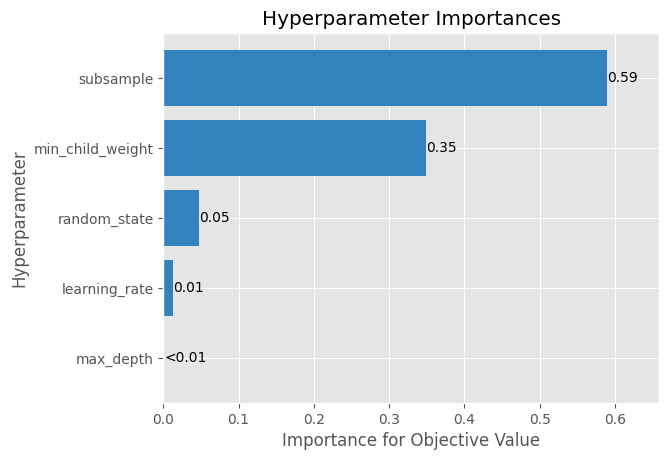

In [36]:
plot_param_importances(find_params)

In [37]:
best_params={'subsample': 0.30000000000000004,
 'learning_rate': 0.003,
 'max_depth': 3,
 'random_state': 36,
 'min_child_weight': 17}

In [38]:
model=xgb.XGBClassifier(**best_params)

In [39]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [40]:
y_pred=model.predict(X_test)

In [41]:
accuracy_score(y_test,y_pred)

0.39705882352941174

## Why Optuna?

- the ability to define Pythonic search spaces using loops and conditionals.
- Platform-agnostic API — you can tune estimators of almost any ML, DL package/framework, including Sklearn, PyTorch, TensorFlow, Keras, XGBoost, LightGBM, CatBoost, etc.
- a large suite of optimization algorithms with early stopping and pruning features baked in.
- it supports optimization of continuous, integer and categorical hyperparameters, as well as hyperparameters with complex dependencies (the optimal value of a hyperparameter may depend on the values of other hyperparameters).
- Easy parallelization with little or no changes to the code.
- Built-in support for visual exploration of search results.

### Differences between Optuna Hyperparamter vs Grid Search vs Random Search 

| Optuna | Grid Search   | Random Search   |
|------|------|------|
|   Based on trail based, follows Bayesian optimization approach  | It gives the results by picking each and every parameter|  It gives the results based on random picking of each parameter     |
|   Takes much time but gives the best optimized hyperparameters  | Takes much time but gives less optimized results compared to Optuna|  It is faster than compared to Grid Search and but may not gurantee for accurate results compared to Optuna    |
|   Has inbuilt methods for data visulization for plotting the results without typing heavy code | Does not have inbuilt plotting | Does not have inbuilt plotting |
|   it can be used for hyperparameters with complex dependencies  | can be used for hyperparameters with complex dependencie but may not be good compared to Optuna | can be used for hyperparameters with complex dependencie but may not be good compared to Optuna |
|   We can also convert to dataframe for finding best hyperparameters in each trail due to its inbuilt features  | It does not have inbuilt features for visualizing the parameters | It does not have inbuilt features for visualizing the parameters |
|   Robust for larger datasets with optimized results | Cannot be used for larger datasets with many hyper parameters | Can be used for larger datasets with many hyper parameters but may not gurantee the optimized results compared to Optuna |